## Traction Analytics Prediction

### Methodology

1. Data Preparation
- Concat daily downloads of weekly article activities from NewsWhip
- Calculate percentage and absolute change of each article across days

2. Define labels
- Set gradient threshold and abs interaction value threshold
- For each article, build a linear regression model for the facebook interactions over time and obtain the gradient
- If the gradient > threshold | abs interaction count > threshold -> trending
- Else if the gradient < -threshold -> untrending
- Else -> neutral

3. EDA of labels
- Readjust threholds if necessary
- Under or oversampling if necessary

4. Deep learning pipeline (SetFit for Few Shot)
- Tokenise
- Train-test split : 80/20
- Model evaluation using precision, recall and F1
- Model comparison

### Data Preperation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [2]:
# Read and perform basic data processing

# df = pd.read_csv('data/combined_data_merged.csv')
df = pd.read_csv('data/may_june_data_merged.csv')
df = df[['published', 'headline', 'summary', 'link', 'domain','facebook_interactions', 'date_extracted', 'suggested_labels']]
df['published'] = pd.to_datetime(df['published'])
df['date_extracted'] = pd.to_datetime(df['date_extracted'])

# convert suggested_labels to list
df['suggested_labels'] = df['suggested_labels'].apply(lambda x: ast.literal_eval(x))
df['article_theme'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[0])
df['article_index'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[1])

df = df.drop(columns=['suggested_labels'])
df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)

df

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index
0,2023-04-26 11:00:01,"ðŸ¶ WATCH: In a video posted on TikTok, a gro...","ðŸ¶ WATCH: In a video posted on TikTok, a gro...",https://www.facebook.com/147858757571_10160124...,NaN,1187,2023-05-01,natural disasters,landslide
1,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,696,2023-06-02,general,others
2,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,885,2023-06-03,general,others
3,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,926,2023-06-05,general,others
4,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,938,2023-06-06,general,others
...,...,...,...,...,...,...,...,...,...
15285,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,350,2023-06-03,general,others
15286,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,350,2023-06-05,general,others
15287,2023-06-08 09:47:07,"""A few constituents spoke about the high cost ...","""A few constituents spoke about the high cost ...",https://www.facebook.com/189434891146677_71087...,NaN,12,2023-06-09,general,budget
15288,2023-06-04 02:45:00,"""(The cat) has a collar on it and itâ€™s very ...","""(The cat) has a collar on it and itâ€™s very ...",https://www.facebook.com/345185573000_63837702...,NaN,8,2023-06-04,general,ndp


In [3]:
df["article_index"].value_counts()

others                      8044
sea games                   1293
food prices                  855
ndp                          767
football                     496
border reopening             454
4d/toto                      325
earthquake                   318
deaths                       279
weather                      201
ndr                          196
scams                        169
landslide                    155
world cup                    133
mbs                          131
layoffs                      126
winter olympics              100
nsf                           92
parliament                    90
hari raya                     87
crypto                        74
msia politics                 66
budget                        65
workplace safety              62
chicken supply                60
taxi fares                    52
resale prices                 51
service disruptions           49
safe management measures      44
local athletes                44
coe prices

In [4]:
# Create a dataframe with unique articles only

df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)

# concat headline and summary

df_unique['text'] = df_unique['headline'] + ' ' + df_unique['summary']

# creature a feature for the number of hours since the article of the same article_index was published

df_unique['hours_since_published'] = df_unique.sort_values(by=['published']).groupby(['article_index'])['published'].diff().dt.total_seconds().div(3600)
df_unique['hours_since_published'] = df_unique['hours_since_published'].fillna(0)

df_unique = df_unique.sort_values(by=['article_index', 'published'], ascending=[True, True]).reset_index(drop=True)

# create a feature for day of week published

df_unique['day_of_week_published'] = df_unique['published'].dt.day_name().map({'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,'Sunday': 7})

# create a feature for number of words in headline

df_unique['headline_word_count'] = df_unique['headline'].str.split().str.len()

# create a feature for number of words in summary

df_unique['summary_word_count'] = df_unique['summary'].str.split().str.len()

# create a feature for number of words in text

df_unique['text_word_count'] = df_unique['text'].str.split().str.len()

# create a feature for number of non-stop words in headline and summary

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

df_unique['headline_non_stop_word_count'] = df_unique['headline'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
df_unique['summary_non_stop_word_count'] = df_unique['summary'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))
df_unique['text_non_stop_word_count'] = df_unique['text'].apply(lambda x: len([word for word in str(x).split() if word.lower() not in stop_words]))


# create a feature for number of unique words in headline and summary

df_unique['headline_unique_word_count'] = df_unique['headline'].apply(lambda x: len(set([word for word in str(x).split()])))
df_unique['summary_unique_word_count'] = df_unique['summary'].apply(lambda x: len(set([word for word in str(x).split()])))
df_unique['text_unique_word_count'] = df_unique['text'].apply(lambda x: len(set([word for word in str(x).split()])))

# creature a feature for the sentiment of the headline and summary

from textblob import TextBlob

df_unique['headline_sentiment'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_unique['summary_sentiment'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_unique['text_sentiment'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# create a feature for the subjectivity of the headline and summary

df_unique['headline_subjectivity'] = df_unique['headline'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
df_unique['summary_subjectivity'] = df_unique['summary'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
df_unique['text_subjectivity'] = df_unique['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# remove NA

df_unique = df_unique.dropna()

df_unique

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,text_non_stop_word_count,headline_unique_word_count,summary_unique_word_count,text_unique_word_count,headline_sentiment,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,36,20,38,50,0.00,0.228571,0.228571,0.000000,0.482143,0.482143
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,22,11,15,24,-0.05,0.000000,-0.033333,0.233333,0.000000,0.155556
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,28,16,22,37,0.15,0.250000,0.200000,0.162500,0.408333,0.285417
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,29,16,31,38,0.25,0.200000,0.233333,0.150000,0.100000,0.133333
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,15,16,2,18,0.20,0.000000,0.200000,0.600000,0.000000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,2023-06-08 15:40:03,Players at Women's World Cup guaranteed at lea...,The minimum directed prize money is more than ...,https://www.facebook.com/129011692114_56682455...,straitstimes.com,20,2023-06-09,sports,world cup,Players at Women's World Cup guaranteed at lea...,...,18,11,17,28,-0.30,0.175000,0.016667,0.400000,0.450000,0.433333
4347,2023-06-10 03:56:06,"Danelle Tan, 18, will be 1st S'porean & Asian ...","YEAH, uh-huh, you know what it is\nBlack and y...",https://www.facebook.com/592308557475467_65027...,mothership.sg,841,2023-06-11,sports,world cup,"Danelle Tan, 18, will be 1st S'porean & Asian ...",...,23,15,10,25,0.00,-0.083333,-0.074074,0.000000,0.216667,0.192593
4348,2023-06-12 09:29:55,Wong Li Lin didn't defend her act of clinging ...,Not sure who so free.,https://www.facebook.com/592308557475467_65178...,babelfish.mothership.sg,270,2023-06-13,sports,world cup,Wong Li Lin didn't defend her act of clinging ...,...,14,18,5,23,0.00,0.075000,0.075000,0.000000,0.844444,0.844444
4349,2023-06-15 22:50:35,Manchester United discusses granting exclusivi...,If the US$6 billion-plus deal for Manchester U...,https://www.facebook.com/93889432933_640469771...,channelnewsasia.com,236,2023-06-16,sports,world cup,Manchester United discusses granting exclusivi...,...,24,13,20,28,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


### Domain Analysis

In [5]:
df_unique['domain'].value_counts()

straitstimes.com                    784
mothership.sg                       742
channelnewsasia.com                 471
asiaone.com                         433
mustsharenews.com                   260
sg.style.yahoo.com                  199
sg.news.yahoo.com                   189
stomp.straitstimes.com              142
todayonline.com                     128
tnp.straitstimes.com                113
cnalifestyle.channelnewsasia.com    111
goodyfeed.com                        73
businesstimes.com.sg                 73
sg.finance.yahoo.com                 39
theonlinecitizen.com                 37
theindependent.sg                    34
babelfish.mothership.sg              24
coconuts.co                          13
ricemedia.co                         12
au.news.yahoo.com                    11
cnaluxury.channelnewsasia.com        10
uk.news.yahoo.com                     4
eatbook.sg                            2
finance.yahoo.com                     2
au.lifestyle.yahoo.com                2


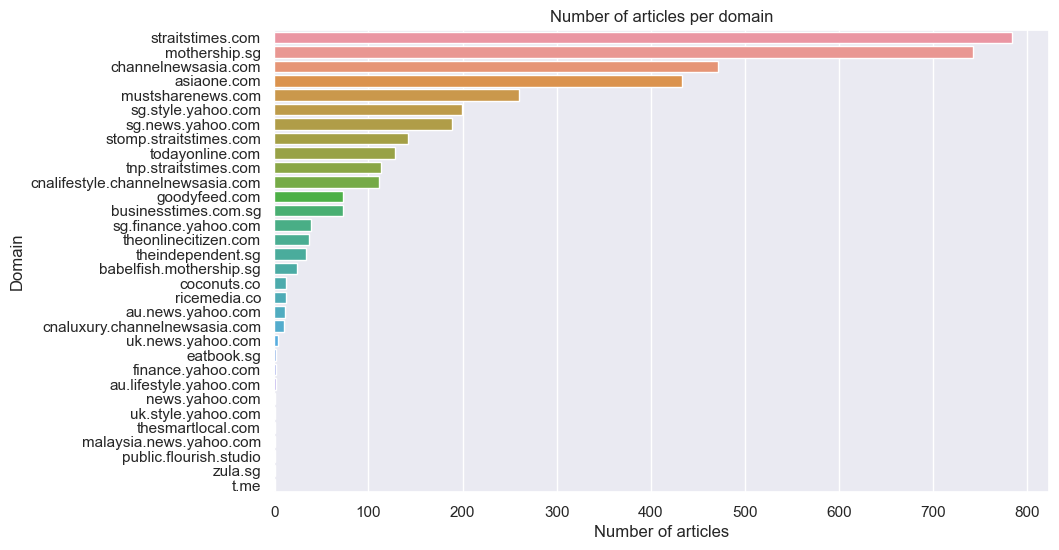

In [6]:
#plot the number of articles per domain

plt.figure(figsize=(10, 6))
sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
plt.title('Number of articles per domain')
plt.xlabel('Number of articles')
plt.ylabel('Domain')
plt.show()

In [7]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key
        
reverse_domain_map

{'asiaone.com': 'asiaone',
 'businesstimes.com.sg': 'businesstimes',
 'channelnewsasia.com': 'channelnewsasia',
 'cnalifestyle.channelnewsasia.com': 'channelnewsasia',
 'cnaluxury.channelnewsasia.com': 'channelnewsasia',
 'goodyfeed.com': 'goodyfeed',
 'babelfish.mothership.sg': 'mothership',
 'mothership.sg': 'mothership',
 'mustsharenews.com': 'mustsharenews',
 'ricemedia.co': 'ricemedia',
 'straitstimes.com': 'straitstimes',
 'stomp.straitstimes.com': 'stomp',
 'tnp.straitstimes.com': 'thenewpaper',
 'theonlinecitizen.com': 'theonlinecitizen',
 'todayonline.com': 'today',
 'sg.finance.yahoo.com': 'yahoosingapore',
 'sg.news.yahoo.com': 'yahoosingapore',
 'sg.style.yahoo.com': 'yahoosingapore'}

In [8]:
domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],

}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})
traffic_table

,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,asiaone,4990000,1290000
1,businesstimes,1630000,622688
2,channelnewsasia,14760000,2330000
3,goodyfeed,891376,461731
4,mothership,6770000,1660000
5,mustsharenews,2010000,823526
6,ricemedia,148791,86394
7,straitstimes,12310000,2230000
8,stomp,1270000,427113
9,theindependent,2370000,683818


Filtering data to include only articles present in mapping table

In [9]:
df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index
1,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,696,2023-06-02,general,others
2,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,885,2023-06-03,general,others
3,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,926,2023-06-05,general,others
4,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,938,2023-06-06,general,others
5,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,944,2023-06-07,general,others
...,...,...,...,...,...,...,...,...,...
15252,2023-06-18 03:33:40,#Fitspo: 60-year-old dad Marcus Teo keeps fit ...,Marcus continues to lead an active life amid f...,https://www.facebook.com/345185573000_64725040...,sg.news.yahoo.com,554,2023-06-21,general,others
15253,2023-06-18 03:33:40,#Fitspo: 60-year-old dad Marcus Teo keeps fit ...,Marcus continues to lead an active life amid f...,https://www.facebook.com/345185573000_64725040...,sg.news.yahoo.com,725,2023-06-22,general,others
15284,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,349,2023-06-02,general,others
15285,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,350,2023-06-03,general,others


In [10]:
df_filtered = df_unique[df_unique["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df_filtered

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,text_non_stop_word_count,headline_unique_word_count,summary_unique_word_count,text_unique_word_count,headline_sentiment,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,36,20,38,50,0.00,0.228571,0.228571,0.000000,0.482143,0.482143
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,22,11,15,24,-0.05,0.000000,-0.033333,0.233333,0.000000,0.155556
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,28,16,22,37,0.15,0.250000,0.200000,0.162500,0.408333,0.285417
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,29,16,31,38,0.25,0.200000,0.233333,0.150000,0.100000,0.133333
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,15,16,2,18,0.20,0.000000,0.200000,0.600000,0.000000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,2023-06-08 15:40:03,Players at Women's World Cup guaranteed at lea...,The minimum directed prize money is more than ...,https://www.facebook.com/129011692114_56682455...,straitstimes.com,20,2023-06-09,sports,world cup,Players at Women's World Cup guaranteed at lea...,...,18,11,17,28,-0.30,0.175000,0.016667,0.400000,0.450000,0.433333
4347,2023-06-10 03:56:06,"Danelle Tan, 18, will be 1st S'porean & Asian ...","YEAH, uh-huh, you know what it is\nBlack and y...",https://www.facebook.com/592308557475467_65027...,mothership.sg,841,2023-06-11,sports,world cup,"Danelle Tan, 18, will be 1st S'porean & Asian ...",...,23,15,10,25,0.00,-0.083333,-0.074074,0.000000,0.216667,0.192593
4348,2023-06-12 09:29:55,Wong Li Lin didn't defend her act of clinging ...,Not sure who so free.,https://www.facebook.com/592308557475467_65178...,babelfish.mothership.sg,270,2023-06-13,sports,world cup,Wong Li Lin didn't defend her act of clinging ...,...,14,18,5,23,0.00,0.075000,0.075000,0.000000,0.844444,0.844444
4349,2023-06-15 22:50:35,Manchester United discusses granting exclusivi...,If the US$6 billion-plus deal for Manchester U...,https://www.facebook.com/93889432933_640469771...,channelnewsasia.com,236,2023-06-16,sports,world cup,Manchester United discusses granting exclusivi...,...,24,13,20,28,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
# mapping domain to domain group

df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)
df_filtered

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\2727172548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,headline_unique_word_count,summary_unique_word_count,text_unique_word_count,headline_sentiment,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity,domain_group
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,20,38,50,0.00,0.228571,0.228571,0.000000,0.482143,0.482143,asiaone
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,11,15,24,-0.05,0.000000,-0.033333,0.233333,0.000000,0.155556,thenewpaper
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,16,22,37,0.15,0.250000,0.200000,0.162500,0.408333,0.285417,straitstimes
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,16,31,38,0.25,0.200000,0.233333,0.150000,0.100000,0.133333,asiaone
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,16,2,18,0.20,0.000000,0.200000,0.600000,0.000000,0.600000,mothership
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346,2023-06-08 15:40:03,Players at Women's World Cup guaranteed at lea...,The minimum directed prize money is more than ...,https://www.facebook.com/129011692114_56682455...,straitstimes.com,20,2023-06-09,sports,world cup,Players at Women's World Cup guaranteed at lea...,...,11,17,28,-0.30,0.175000,0.016667,0.400000,0.450000,0.433333,straitstimes
4347,2023-06-10 03:56:06,"Danelle Tan, 18, will be 1st S'porean & Asian ...","YEAH, uh-huh, you know what it is\nBlack and y...",https://www.facebook.com/592308557475467_65027...,mothership.sg,841,2023-06-11,sports,world cup,"Danelle Tan, 18, will be 1st S'porean & Asian ...",...,15,10,25,0.00,-0.083333,-0.074074,0.000000,0.216667,0.192593,mothership
4348,2023-06-12 09:29:55,Wong Li Lin didn't defend her act of clinging ...,Not sure who so free.,https://www.facebook.com/592308557475467_65178...,babelfish.mothership.sg,270,2023-06-13,sports,world cup,Wong Li Lin didn't defend her act of clinging ...,...,18,5,23,0.00,0.075000,0.075000,0.000000,0.844444,0.844444,mothership
4349,2023-06-15 22:50:35,Manchester United discusses granting exclusivi...,If the US$6 billion-plus deal for Manchester U...,https://www.facebook.com/93889432933_640469771...,channelnewsasia.com,236,2023-06-16,sports,world cup,Manchester United discusses granting exclusivi...,...,13,20,28,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,channelnewsasia


In [12]:
# merge traffic table with df_filtered on domain and domain_group respectively

df_unique = df_filtered.merge(traffic_table, on='domain_group', how='left')
df_unique


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,text_unique_word_count,headline_sentiment,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,50,0.00,0.228571,0.228571,0.000000,0.482143,0.482143,asiaone,4990000,1290000
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,24,-0.05,0.000000,-0.033333,0.233333,0.000000,0.155556,thenewpaper,707314,350734
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,37,0.15,0.250000,0.200000,0.162500,0.408333,0.285417,straitstimes,12310000,2230000
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,38,0.25,0.200000,0.233333,0.150000,0.100000,0.133333,asiaone,4990000,1290000
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,18,0.20,0.000000,0.200000,0.600000,0.000000,0.600000,mothership,6770000,1660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2023-06-08 15:40:03,Players at Women's World Cup guaranteed at lea...,The minimum directed prize money is more than ...,https://www.facebook.com/129011692114_56682455...,straitstimes.com,20,2023-06-09,sports,world cup,Players at Women's World Cup guaranteed at lea...,...,28,-0.30,0.175000,0.016667,0.400000,0.450000,0.433333,straitstimes,12310000,2230000
3836,2023-06-10 03:56:06,"Danelle Tan, 18, will be 1st S'porean & Asian ...","YEAH, uh-huh, you know what it is\nBlack and y...",https://www.facebook.com/592308557475467_65027...,mothership.sg,841,2023-06-11,sports,world cup,"Danelle Tan, 18, will be 1st S'porean & Asian ...",...,25,0.00,-0.083333,-0.074074,0.000000,0.216667,0.192593,mothership,6770000,1660000
3837,2023-06-12 09:29:55,Wong Li Lin didn't defend her act of clinging ...,Not sure who so free.,https://www.facebook.com/592308557475467_65178...,babelfish.mothership.sg,270,2023-06-13,sports,world cup,Wong Li Lin didn't defend her act of clinging ...,...,23,0.00,0.075000,0.075000,0.000000,0.844444,0.844444,mothership,6770000,1660000
3838,2023-06-15 22:50:35,Manchester United discusses granting exclusivi...,If the US$6 billion-plus deal for Manchester U...,https://www.facebook.com/93889432933_640469771...,channelnewsasia.com,236,2023-06-16,sports,world cup,Manchester United discusses granting exclusivi...,...,28,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,channelnewsasia,14760000,2330000


In [13]:
# Calculate the absolute and percentage change in facebook interactions for each article

df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
# df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)
df

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\1948972086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change
1,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,696,2023-06-02,general,others,0.0
2,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,885,2023-06-03,general,others,189.0
3,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,926,2023-06-05,general,others,41.0
4,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,938,2023-06-06,general,others,12.0
5,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,944,2023-06-07,general,others,6.0
...,...,...,...,...,...,...,...,...,...,...
15252,2023-06-18 03:33:40,#Fitspo: 60-year-old dad Marcus Teo keeps fit ...,Marcus continues to lead an active life amid f...,https://www.facebook.com/345185573000_64725040...,sg.news.yahoo.com,554,2023-06-21,general,others,57.0
15253,2023-06-18 03:33:40,#Fitspo: 60-year-old dad Marcus Teo keeps fit ...,Marcus continues to lead an active life amid f...,https://www.facebook.com/345185573000_64725040...,sg.news.yahoo.com,725,2023-06-22,general,others,171.0
15284,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,349,2023-06-02,general,others,0.0
15285,2023-05-29 01:30:02,"""Cannabis Leaves"" Design on Woodleigh HDB Bloc...",Finally an official answer after it was first ...,https://www.facebook.com/1460114364294601_3125...,goodyfeed.com,350,2023-06-03,general,others,1.0


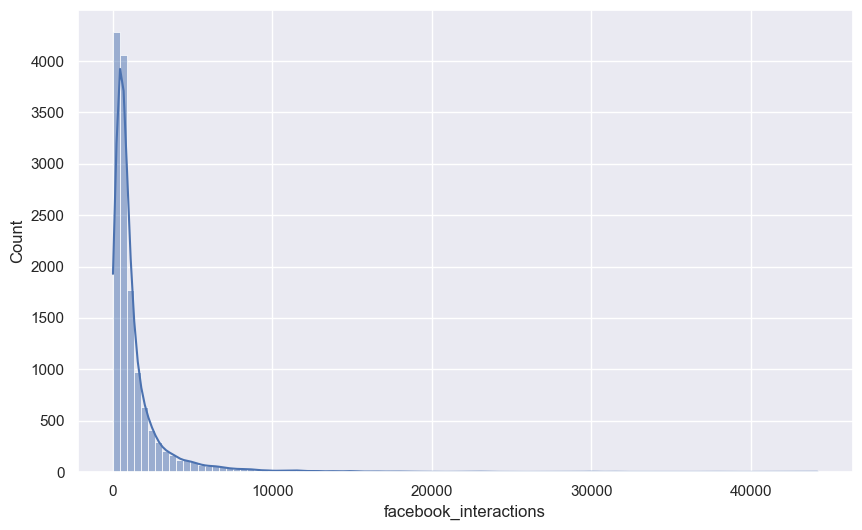

In [14]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions', bins=100, kde=True)
plt.show()


#### Using gradient within each article

Benefits:
- Smoothens based on weekly activities

Issues:
- Reduces impact of spikes
- Gradient threshold not very explainable

In [15]:
from sklearn.linear_model import LinearRegression

# calculating mean and gradient of facebook interactions for each article

def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)

    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]

    return mean, gradient


In [16]:
# Create a dataframe with unique articles and their corresponding labels

df_labels = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()

# Merge the unique articles dataframe with the labels dataframe

df_labelled = df_unique.merge(df_labels, on='link', how='left')
df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,summary_sentiment,text_sentiment,headline_subjectivity,summary_subjectivity,text_subjectivity,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,mean,gradient
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,0.228571,0.228571,0.000000,0.482143,0.482143,asiaone,4990000,1290000,5109.0,0.0
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,0.000000,-0.033333,0.233333,0.000000,0.155556,thenewpaper,707314,350734,1180.0,0.0
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,0.250000,0.200000,0.162500,0.408333,0.285417,straitstimes,12310000,2230000,6310.0,0.0
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,0.200000,0.233333,0.150000,0.100000,0.133333,asiaone,4990000,1290000,2593.0,0.0
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,0.000000,0.200000,0.600000,0.000000,0.600000,mothership,6770000,1660000,620.0,0.0


In [17]:
# Convert negative gradient to 0

df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)

In [18]:
# normalising the mean and gradient values on a gaussian distribution

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_log'] = np.log(df_labelled['mean'])
df_labelled['gradient_log'] = np.log(df_labelled['gradient'])



e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


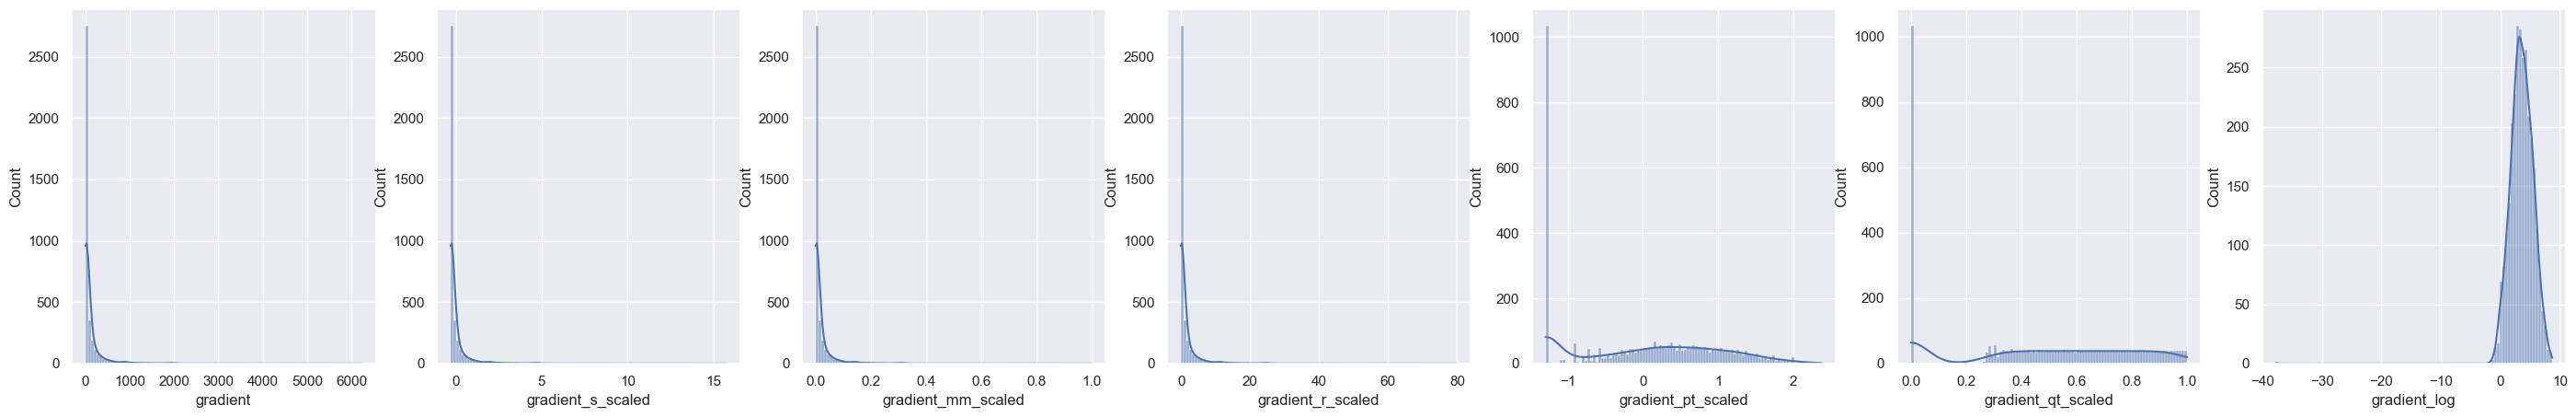

In [19]:
# plotting the distribution of gradient and scaled gradients for each article on multi plot

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
plt.show()


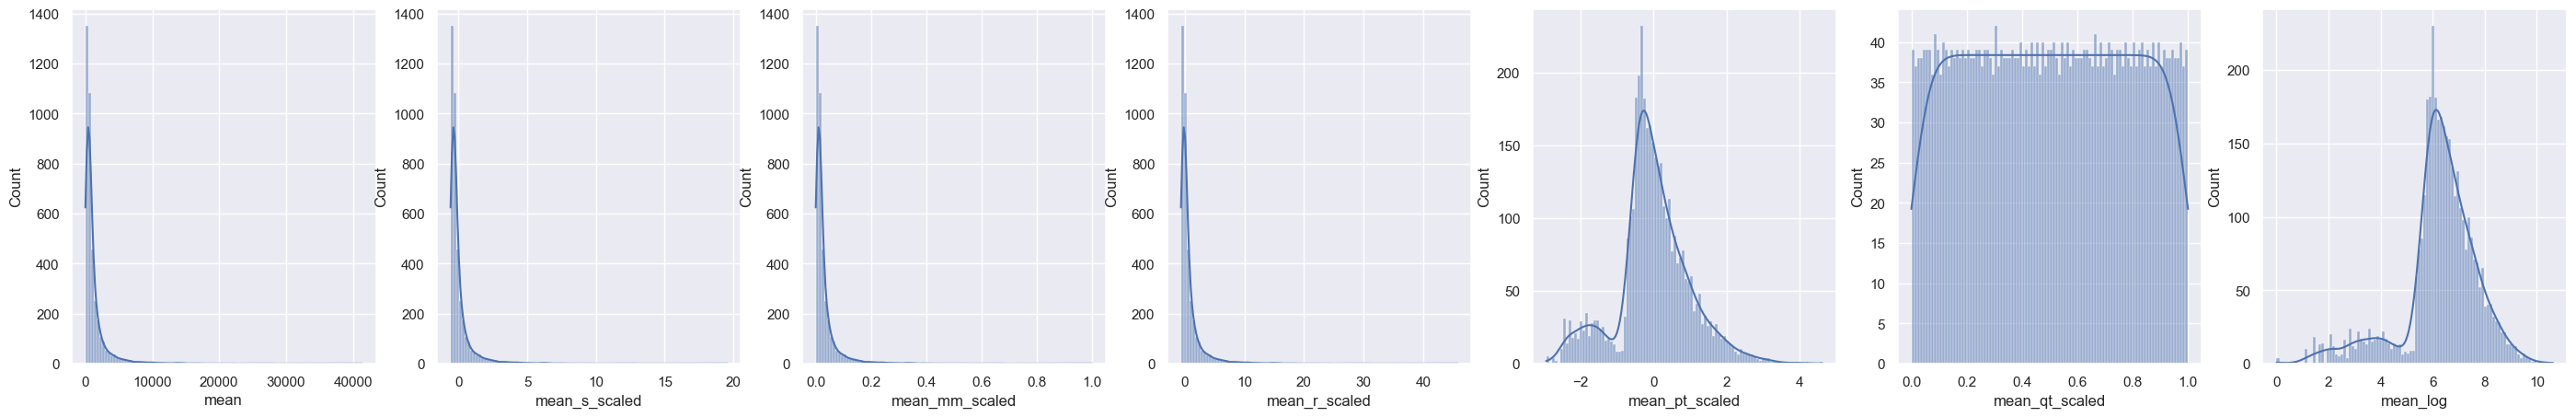

In [20]:
# plotting the distribution of mean  and scaled means for each article on multi plot

fig, ax = plt.subplots(1, 7, figsize=(35,5))
sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
sns.histplot(data=df_labelled, x='mean_log', bins=100, kde=True, ax=ax[6])
plt.show()


In [21]:
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,mean_mm_scaled,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,0.123548,0.0,5.086245,-0.197961,1.897729,-1.292261,0.962902,0.0,8.538759,-inf
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,0.028535,0.0,0.671874,-0.197961,0.495548,-1.292261,0.740924,0.0,7.073270,-inf
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,0.152591,0.0,6.435611,-0.197961,2.130781,-1.292261,0.975486,0.0,8.749891,-inf
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,0.062705,0.0,2.259430,-0.197961,1.204379,-1.292261,0.896123,0.0,7.860571,-inf
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,0.014993,0.0,0.042694,-0.197961,-0.015879,-1.292261,0.526527,0.0,6.429719,-inf


In [22]:
GRD_THRESHOLD_UPPER = 1
GRD_THRESHOLD_LOWER = -1
VAL_ARR_THRESHOLD_UPPER = 1
VAL_ARR_THRESHOLD_LOWER = -1

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"

In [23]:
# label each row

df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,0.0,5.086245,-0.197961,1.897729,-1.292261,0.962902,0.0,8.538759,-inf,trending
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,0.0,0.671874,-0.197961,0.495548,-1.292261,0.740924,0.0,7.073270,-inf,diminishing
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,0.0,6.435611,-0.197961,2.130781,-1.292261,0.975486,0.0,8.749891,-inf,trending
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,0.0,2.259430,-0.197961,1.204379,-1.292261,0.896123,0.0,7.860571,-inf,trending
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,0.0,0.042694,-0.197961,-0.015879,-1.292261,0.526527,0.0,6.429719,-inf,diminishing


### EDA of target variables

In [24]:
# Perform basic data exploration of target variable

df_labelled['label'].value_counts()


neutral        1944
diminishing    1017
trending        879
Name: label, dtype: int64

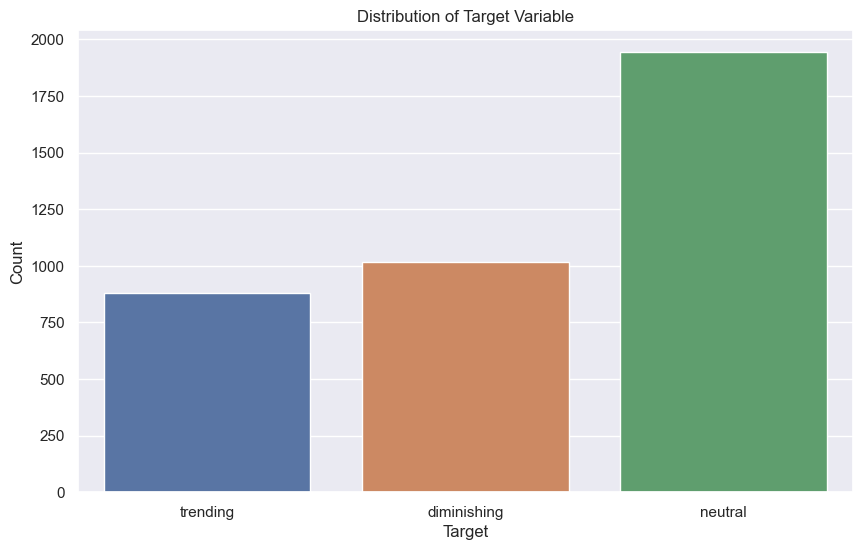

In [25]:
# Plot the distribution of target variable using Seaborn. 

plt.figure(figsize=(10, 6))
sns.countplot(data=df_labelled, x='label')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [26]:
# merge the labelled dataframe with the original dataframe to get the full dataset with labels

df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
df_combined.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change,label
0,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,696,2023-06-02,general,others,0.0,neutral
1,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,885,2023-06-03,general,others,189.0,neutral
2,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,926,2023-06-05,general,others,41.0,neutral
3,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,938,2023-06-06,general,others,12.0,neutral
4,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,944,2023-06-07,general,others,6.0,neutral


In [27]:
unique_articles = df_combined['link'].unique()
new_df = pd.DataFrame()

for article in unique_articles:
    df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
    df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
    df_slice['day'] = df_slice['day'] + 1

    new_df = new_df.append(df_slice)

new_df.head(20)

,day,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change,label
0,1,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,696,2023-06-02,general,others,0.0,neutral
1,2,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,885,2023-06-03,general,others,189.0,neutral
2,3,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,926,2023-06-05,general,others,41.0,neutral
3,4,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,938,2023-06-06,general,others,12.0,neutral
4,5,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,944,2023-06-07,general,others,6.0,neutral
5,6,2023-06-01 06:40:01,â€˜Why is your client smiling?' Judge asks law...,Darren Yeo Wei Hong used a hidden camera disgu...,https://www.facebook.com/129011692114_10159241...,straitstimes.com,944,2023-06-08,general,others,0.0,neutral
0,1,2023-05-01 03:07:55,â€˜We will always have your back': 4G team wil...,"""As we grow the economy, we will also fight th...",https://www.facebook.com/129011692114_10159181...,straitstimes.com,360,2023-05-02,jobs and economy,others,0.0,neutral
1,2,2023-05-01 03:07:55,â€˜We will always have your back': 4G team wil...,"""As we grow the economy, we will also fight th...",https://www.facebook.com/129011692114_10159181...,straitstimes.com,382,2023-05-04,jobs and economy,others,22.0,neutral
2,3,2023-05-01 03:07:55,â€˜We will always have your back': 4G team wil...,"""As we grow the economy, we will also fight th...",https://www.facebook.com/129011692114_10159181...,straitstimes.com,391,2023-05-05,jobs and economy,others,9.0,neutral
3,4,2023-05-01 03:07:55,â€˜We will always have your back': 4G team wil...,"""As we grow the economy, we will also fight th...",https://www.facebook.com/129011692114_10159181...,straitstimes.com,392,2023-05-07,jobs and economy,others,1.0,neutral


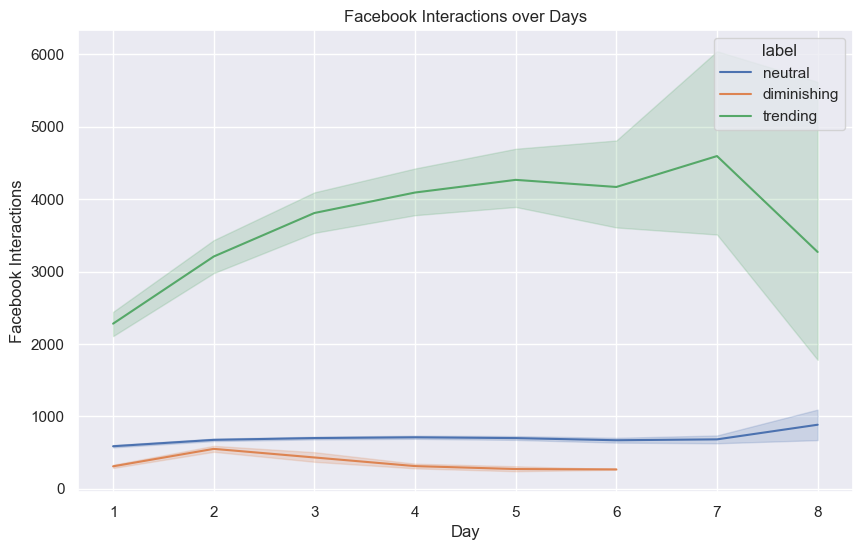

In [28]:
# Plot the facebook interactions for each article over days, coloured by label

plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='day', y='facebook_interactions', hue='label')
plt.title('Facebook Interactions over Days')
plt.xlabel('Day')
plt.ylabel('Facebook Interactions')
plt.show()

In [29]:
# previewing trending articles

df_labelled[df_labelled['label'] == 'trending'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,0.000000,5.086245,-0.197961,1.897729,-1.292261,0.962902,0.000000,8.538759,-inf,trending
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,0.000000,6.435611,-0.197961,2.130781,-1.292261,0.975486,0.000000,8.749891,-inf,trending
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,0.000000,2.259430,-0.197961,1.204379,-1.292261,0.896123,0.000000,7.860571,-inf,trending
6,2023-04-27 08:30:19,M'sian retiree spends S$1.20 on lottery ticket...,The 70-year-old man from Negeri Sembilan said ...,https://www.facebook.com/592308557475467_65688...,mothership.sg,3394,2023-05-01,general,4d/toto,M'sian retiree spends S$1.20 on lottery ticket...,...,0.020443,3.332406,1.441383,1.514829,0.993296,0.931910,0.810603,8.174139,4.848116,trending
7,2023-04-28 09:15:12,Huat ah! Punter wins $5.5m Toto from Bukit Mer...,"Singaporeans are obsessed with 4D numbers, Tot...",https://www.facebook.com/121790674546188_63611...,asiaone.com,2854,2023-05-01,general,4d/toto,Huat ah! Punter wins $5.5m Toto from Bukit Mer...,...,0.027032,2.877936,1.969831,1.392978,1.104111,0.920089,0.844459,8.053092,5.127529,trending


In [30]:
# previewing not trending articles

df_labelled[df_labelled['label'] == 'diminishing'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,0.0,0.671874,-0.197961,0.495548,-1.292261,0.740924,0.0,7.073270,-inf,diminishing
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,0.0,0.042694,-0.197961,-0.015879,-1.292261,0.526527,0.0,6.429719,-inf,diminishing
40,2023-05-19 00:30:03,"'Wah, must buy 4D': Punters win after betting ...",The stall number came out 3 different ways!,https://www.facebook.com/39533052294_101602841...,tnp.straitstimes.com,1185,2023-05-22,general,4d/toto,"'Wah, must buy 4D': Punters win after betting ...",...,0.0,0.677492,-0.197961,0.499101,-1.292261,0.741427,0.0,7.077498,-inf,diminishing
44,2023-05-31 03:59:11,Taiwanese Host Jacky Wu Draws Massive Crowds A...,The crowd parted like the Red Sea to let the s...,https://www.facebook.com/292279440975148_57186...,mustsharenews.com,70,2023-06-01,general,4d/toto,Taiwanese Host Jacky Wu Draws Massive Crowds A...,...,0.0,-0.575250,-0.197961,-1.375387,-1.292261,0.100518,0.0,4.248495,-inf,diminishing
45,2023-05-31 05:30:02,Migrant Worker Shows Epic Reaction After Winni...,"The event was ""Squid Game""-themed with the wor...",https://www.facebook.com/1460114364294601_3126...,goodyfeed.com,110,2023-06-01,general,4d/toto,Migrant Worker Shows Epic Reaction After Winni...,...,0.0,-0.530309,-0.197961,-1.135460,-1.292261,0.114114,0.0,4.700480,-inf,diminishing


In [31]:
# # concatenate headline and summary columns
# df_labelled['text'] = df_labelled['headline'] + ' ' + df_labelled['summary']

In [32]:
df_labelled

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,text,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
0,2023-04-24 06:32:56,'I don't have the heart to criticise them': Ja...,"""Everyone who has the courage to sing on stage...",https://www.facebook.com/121790674546188_63480...,asiaone.com,5109,2023-05-01,general,4d/toto,'I don't have the heart to criticise them': Ja...,...,0.000000,5.086245,-0.197961,1.897729,-1.292261,0.962902,0.000000,8.538759,-inf,trending
1,2023-04-24 07:00:06,Blackpink's Born Pink is highest grossing tour...,Blackpink broke the record held by British gir...,https://www.facebook.com/39533052294_101602347...,tnp.straitstimes.com,1180,2023-05-01,general,4d/toto,Blackpink's Born Pink is highest grossing tour...,...,0.000000,0.671874,-0.197961,0.495548,-1.292261,0.740924,0.000000,7.073270,-inf,diminishing
2,2023-04-24 10:20:02,$201k jackpot: US man wins lottery 3 times in ...,"â€œIt hit last year, and it hit again,â€ said...",https://www.facebook.com/129011692114_10159168...,straitstimes.com,6310,2023-05-01,general,4d/toto,$201k jackpot: US man wins lottery 3 times in ...,...,0.000000,6.435611,-0.197961,2.130781,-1.292261,0.975486,0.000000,8.749891,-inf,trending
3,2023-04-26 01:49:26,"Singapore resident wins $122,000 on India's Wh...",Singapore resident Shashwat Goel won 7.5 milli...,https://www.facebook.com/121790674546188_63539...,asiaone.com,2593,2023-05-01,general,4d/toto,"Singapore resident wins $122,000 on India's Wh...",...,0.000000,2.259430,-0.197961,1.204379,-1.292261,0.896123,0.000000,7.860571,-inf,trending
4,2023-04-27 03:58:18,Jacky Cheung S'pore concert tickets sell out f...,Flipping culture.,https://www.facebook.com/592308557475467_65683...,mothership.sg,620,2023-05-02,general,4d/toto,Jacky Cheung S'pore concert tickets sell out f...,...,0.000000,0.042694,-0.197961,-0.015879,-1.292261,0.526527,0.000000,6.429719,-inf,diminishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2023-06-08 15:40:03,Players at Women's World Cup guaranteed at lea...,The minimum directed prize money is more than ...,https://www.facebook.com/129011692114_56682455...,straitstimes.com,20,2023-06-09,sports,world cup,Players at Women's World Cup guaranteed at lea...,...,0.000000,-0.631427,-0.197961,-1.942445,-1.292261,0.047506,0.000000,2.995732,-inf,diminishing
3836,2023-06-10 03:56:06,"Danelle Tan, 18, will be 1st S'porean & Asian ...","YEAH, uh-huh, you know what it is\nBlack and y...",https://www.facebook.com/592308557475467_65027...,mothership.sg,841,2023-06-11,sports,world cup,"Danelle Tan, 18, will be 1st S'porean & Asian ...",...,0.001901,0.381200,-0.045507,0.292043,-0.004040,0.667547,0.463731,6.825770,2.472930,neutral
3837,2023-06-12 09:29:55,Wong Li Lin didn't defend her act of clinging ...,Not sure who so free.,https://www.facebook.com/592308557475467_65178...,babelfish.mothership.sg,270,2023-06-13,sports,world cup,Wong Li Lin didn't defend her act of clinging ...,...,0.000899,-0.304478,-0.125867,-0.503886,-0.320278,0.214719,0.380062,5.739793,1.724041,neutral
3838,2023-06-15 22:50:35,Manchester United discusses granting exclusivi...,If the US$6 billion-plus deal for Manchester U...,https://www.facebook.com/93889432933_640469771...,channelnewsasia.com,236,2023-06-16,sports,world cup,Manchester United discusses granting exclusivi...,...,0.006213,-0.085228,0.300271,-0.165569,0.502914,0.440471,0.648268,6.226819,3.657131,neutral


In [33]:
# remove articles with indexes having less than 2 occurences.

df_labelled = df_labelled[~df_labelled["article_index"].isin(df_labelled.groupby('article_index').count()['link'].sort_values(ascending=False)[df_labelled.groupby('article_index').count()['link'].sort_values(ascending=False) < 2].index.tolist())]

In [34]:
df_labelled['label'].value_counts().sort_values(ascending=False)

neutral        1939
diminishing    1015
trending        879
Name: label, dtype: int64

In [35]:
# getting label for each article_theme based on mode of labels for each article_theme

aggregated_labels = df_labelled.groupby('article_index')['label'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
aggregated_labels

,article_index,label
0,4d/toto,neutral
1,banks,diminishing
2,border reopening,neutral
3,budget,diminishing
4,case numbers,neutral
5,chicken supply,diminishing
6,coe prices,neutral
7,core inflation,diminishing
8,crypto,neutral
9,currency,neutral


In [36]:
df_labelled.groupby('article_index').count()['link'].sort_values(ascending=False).reset_index()

,article_index,link
0,others,2122
1,sea games,299
2,food prices,229
3,ndp,168
4,border reopening,112
5,football,108
6,deaths,77
7,4d/toto,69
8,ndr,56
9,weather,51


In [37]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
aggregated_labels['label'] = aggregated_labels['label'].map(label_mapper)
aggregated_labels

,article_index,label
0,4d/toto,1
1,banks,0
2,border reopening,1
3,budget,0
4,case numbers,1
5,chicken supply,0
6,coe prices,1
7,core inflation,0
8,crypto,1
9,currency,1


In [38]:
aggregated_labels.sort_values(by='label', ascending=False)

,article_index,label
23,local athletes,2
17,hari raya,2
40,teachers,2
35,scams,1
25,mbs,1
26,msia politics,1
27,ndp,1
29,nsf,1
30,others,1
33,resale prices,1


## Deep Learning Approaches

1. SetFit with Text Features only (Summary + Headline)
2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors)
3. Combined models - Concat text embeddings with numerical features

#### 1. SetFit with Text Features only (Summary + Headline)


In [39]:
from datasets import load_dataset, Features, Value
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})


def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

In [41]:
df_labelled_m1 = df_labelled.copy()
df_labelled_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3833 entries, 0 to 3839
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   published                     3833 non-null   datetime64[ns]
 1   headline                      3833 non-null   object        
 2   summary                       3833 non-null   object        
 3   link                          3833 non-null   object        
 4   domain                        3833 non-null   object        
 5   facebook_interactions         3833 non-null   int64         
 6   date_extracted                3833 non-null   datetime64[ns]
 7   article_theme                 3833 non-null   object        
 8   article_index                 3833 non-null   object        
 9   text                          3833 non-null   object        
 10  hours_since_published         3833 non-null   float64       
 11  day_of_week_published         

In [42]:
df_train_test_m1 = df_labelled_m1[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
df_train_test_m1

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,'I don't have the heart to criticise them': Ja...,4990000,1290000,4d/toto,trending
1,Blackpink's Born Pink is highest grossing tour...,707314,350734,4d/toto,diminishing
2,$201k jackpot: US man wins lottery 3 times in ...,12310000,2230000,4d/toto,trending
3,"Singapore resident wins $122,000 on India's Wh...",4990000,1290000,4d/toto,trending
4,Jacky Cheung S'pore concert tickets sell out f...,6770000,1660000,4d/toto,diminishing
...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,12310000,2230000,world cup,diminishing
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",6770000,1660000,world cup,neutral
3837,Wong Li Lin didn't defend her act of clinging ...,6770000,1660000,world cup,neutral
3838,Manchester United discusses granting exclusivi...,14760000,2330000,world cup,neutral


In [43]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)

# Train test split

train_df_m1, test_df_m1 = train_test_split(df_train_test_m1, test_size=0.2, random_state=42, stratify=df_train_test_m1['article_index'])

train_df_m1.to_parquet('data/train_df_m1.parquet')
test_df_m1.to_parquet('data/test_df_m1.parquet')

dataset_m1 = load_dataset("parquet", data_files={'train': "data/train_df_m1.parquet", 'test': "data/test_df_m1.parquet"})
train_dataset_m1 = dataset_m1["train"]
test_dataset_m1 = dataset_m1["test"]

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\2536075633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1999.67it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-f051352a853006cf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1000.19it/s]


In [44]:
# Load a SetFit model
model_m1 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m1 = SetFitTrainer(
    model=model_m1,
    train_dataset=train_dataset_m1,
    eval_dataset=test_dataset_m1,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [45]:
trainer_m1.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 14.67it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [10:21<00:00, 621.76s/it]


In [46]:
# evalutating pred_y against test_y

def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})

def get_predictions_agg(test_dataset, pred_y):
    if not isinstance(test_dataset, pd.DataFrame):
        test_dataset_merge = test_dataset.to_pandas()
    else:
        test_dataset_merge = test_dataset.copy()
    test_dataset_merge['pred_y'] = pred_y
    test_dataset_agg = test_dataset_merge.groupby('article_index')['label'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
    pred_agg = test_dataset_merge.groupby('article_index')['pred_y'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
    # return test_dataset_agg, pred_agg
    return test_dataset_agg['label'], pred_agg['pred_y']

In [47]:
test_y_m1 = test_dataset_m1.to_pandas()['label']
pred_y_m1 = model_m1.predict(test_dataset_m1.to_pandas()['text']).numpy()

res_m1 = evaluate_predictions(test_y_m1, pred_y_m1)
res_m1

,macro
accuracy,0.536
precision,0.513
recall,0.468
f1,0.478


In [48]:
test_y_agg_m1_, pred_y_agg_m1_ = get_predictions_agg(test_dataset_m1, pred_y_m1)


In [49]:
test_y_agg_m1, pred_y_agg_m1 = get_predictions_agg(test_dataset_m1, pred_y_m1)
res_agg_m1 = evaluate_predictions(test_y_agg_m1, pred_y_agg_m1)
res_agg_m1

,macro
accuracy,0.545
precision,0.343
recall,0.346
f1,0.330


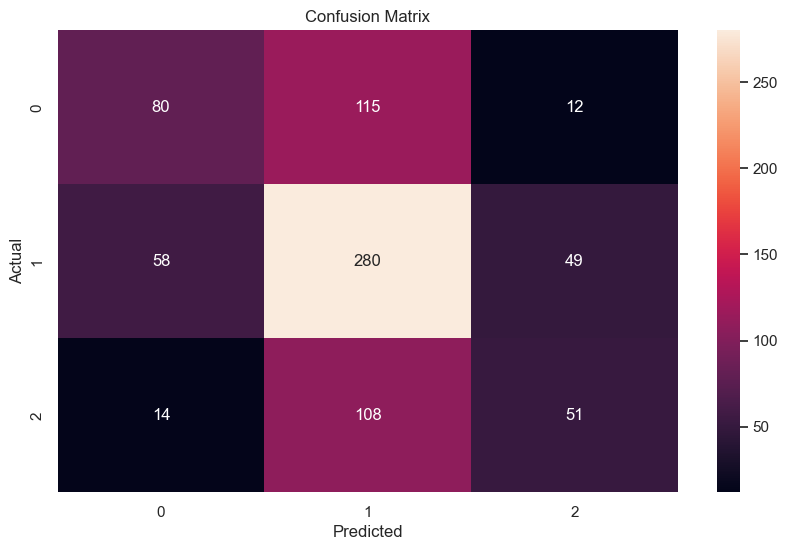

In [50]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

plot_confusion_matrix(test_y_m1, pred_y_m1)

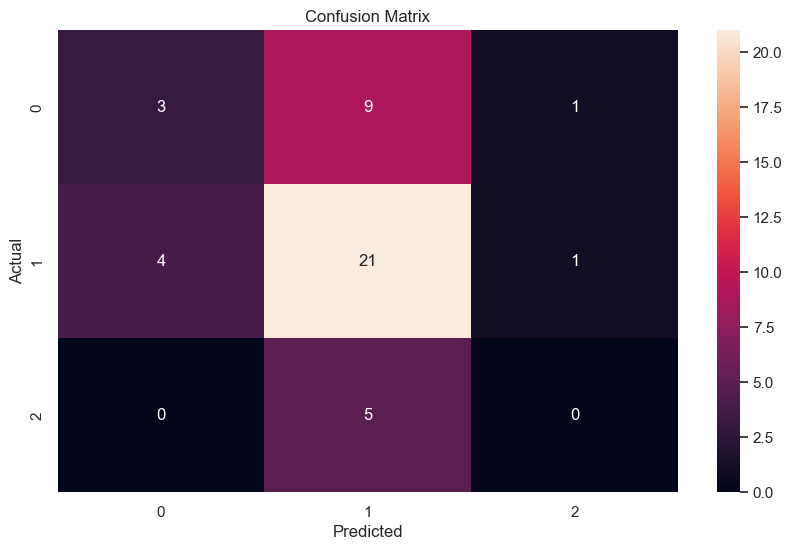

In [51]:
plot_confusion_matrix(test_y_agg_m1, pred_y_agg_m1)

### 2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Additional Features)

In [52]:
df_labelled.columns

Index(['published', 'headline', 'summary', 'link', 'domain',
       'facebook_interactions', 'date_extracted', 'article_theme',
       'article_index', 'text', 'hours_since_published',
       'day_of_week_published', 'headline_word_count', 'summary_word_count',
       'text_word_count', 'headline_non_stop_word_count',
       'summary_non_stop_word_count', 'text_non_stop_word_count',
       'headline_unique_word_count', 'summary_unique_word_count',
       'text_unique_word_count', 'headline_sentiment', 'summary_sentiment',
       'text_sentiment', 'headline_subjectivity', 'summary_subjectivity',
       'text_subjectivity', 'domain_group', 'mean_monthly_visits',
       'mean_monthly_unique_visitors', 'mean', 'gradient', 'mean_s_scaled',
       'gradient_s_scaled', 'mean_mm_scaled', 'gradient_mm_scaled',
       'mean_r_scaled', 'gradient_r_scaled', 'mean_pt_scaled',
       'gradient_pt_scaled', 'mean_qt_scaled', 'gradient_qt_scaled',
       'mean_log', 'gradient_log', 'label'],
      dtyp

In [53]:
df_labelled_m2 = df_labelled.copy()
df_train_test_m2 = df_labelled_m2[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'headline_non_stop_word_count', 'text_subjectivity', 'text_sentiment', 'article_index', 'label']]
df_train_test_m2

,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,headline_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,4990000,1290000,0.000000,1,12,0.482143,0.228571,4d/toto,trending
1,Blackpink's Born Pink is highest grossing tour...,707314,350734,0.452778,1,8,0.155556,-0.033333,4d/toto,diminishing
2,$201k jackpot: US man wins lottery 3 times in ...,12310000,2230000,3.332222,1,11,0.285417,0.200000,4d/toto,trending
3,"Singapore resident wins $122,000 on India's Wh...",4990000,1290000,39.490000,3,10,0.133333,0.233333,4d/toto,trending
4,Jacky Cheung S'pore concert tickets sell out f...,6770000,1660000,26.147778,4,13,0.600000,0.200000,4d/toto,diminishing
...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,12310000,2230000,1.655833,4,8,0.433333,0.016667,world cup,diminishing
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",6770000,1660000,36.267500,6,12,0.192593,-0.074074,world cup,neutral
3837,Wong Li Lin didn't defend her act of clinging ...,6770000,1660000,53.563611,1,12,0.844444,0.075000,world cup,neutral
3838,Manchester United discusses granting exclusivi...,14760000,2330000,85.344444,4,11,0.000000,0.000000,world cup,neutral


In [54]:
label_mapper = {"trending": 2, "diminishing": 0, "neutral": 1}
df_train_test_m2["label"] = df_train_test_m2["label"].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2["text"] = (
    df_train_test_m2["text"]
    + " There are "
    + df_train_test_m2["mean_monthly_visits"].astype(str)
    + " mean monthly visitors to the website and "
    + df_train_test_m2["mean_monthly_unique_visitors"].astype(str)
    + " mean monthly unique visitors to the website."
    + " The article was published "
    + df_train_test_m2["hours_since_published"].astype(str)
    + " hours after the last article of the same theme was published."
    + " The article was published on the "
    + df_train_test_m2["day_of_week_published"].astype(str)
    + " day of the week."
    + " The headline has "
    + df_train_test_m2["headline_non_stop_word_count"].astype(str)
    + " non-stop words."
    + " The text has a subjectivity score of "
    + df_train_test_m2["text_subjectivity"].astype(str)
    + " and a sentiment score of "
    + df_train_test_m2["text_sentiment"].astype(str)
    + "."
)
df_train_test_m2.drop(
    columns=["mean_monthly_visits", "mean_monthly_unique_visitors"], inplace=True
)
df_train_test_m2.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\1979288815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2["label"] = df_train_test_m2["label"].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\1979288815.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2["text"] = (
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,text,hours_since_published,day_of_week_published,headline_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,0.000000,1,12,0.482143,0.228571,4d/toto,2
1,Blackpink's Born Pink is highest grossing tour...,0.452778,1,8,0.155556,-0.033333,4d/toto,0
2,$201k jackpot: US man wins lottery 3 times in ...,3.332222,1,11,0.285417,0.200000,4d/toto,2
3,"Singapore resident wins $122,000 on India's Wh...",39.490000,3,10,0.133333,0.233333,4d/toto,2
4,Jacky Cheung S'pore concert tickets sell out f...,26.147778,4,13,0.600000,0.200000,4d/toto,0


In [55]:
df_train_test_m2.iloc[0].text

'\'I don\'t have the heart to criticise them\': Jacky Cheung on why he rejected 9-digit pay to be mentor on singing competition "Everyone who has the courage to sing on stage â€” even though they aren\'t professional singers â€” are already amazing for being daring enough to sing in front of a large crowd. I don\'t have the heart to criticise them." said Jacky Cheung. There are 4990000 mean monthly visitors to the website and 1290000 mean monthly unique visitors to the website. The article was published 0.0 hours after the last article of the same theme was published. The article was published on the 1 day of the week. The headline has 12 non-stop words. The text has a subjectivity score of 0.48214285714285715 and a sentiment score of 0.2285714285714286.'

In [56]:
# Train test split

train_df_m2, test_df_m2 = train_test_split(df_train_test_m2, test_size=0.2, random_state=42, stratify=df_train_test_m2['article_index'])

train_df_m2.to_parquet('data/train_df_m2.parquet')
test_df_m2.to_parquet('data/test_df_m2.parquet')


dataset_m2 = load_dataset("parquet", data_files={'train': "data/train_df_m2.parquet", 'test': "data/test_df_m2.parquet"})
train_dataset_m2 = dataset_m2["train"]
test_dataset_m2 = dataset_m2["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1198.72it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-502b602b9a5112b6/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1000.67it/s]


In [57]:
# Load a SetFit model
model_m2 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2 = SetFitTrainer(
    model=model_m2,
    train_dataset=train_dataset_m2,
    eval_dataset=test_dataset_m2,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [58]:
trainer_m2.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 13.07it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [24:45<00:00, 1485.07s/it]


In [59]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

In [60]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

res_m2 = evaluate_predictions(test_y_m2, pred_y_m2)
res_m2


,macro
accuracy,0.527
precision,0.504
recall,0.459
f1,0.468


In [61]:
test_y_agg_m2, pred_y_agg_m2 = get_predictions_agg(test_dataset_m2, pred_y_m2)
res_agg_m2 = evaluate_predictions(test_y_agg_m2, pred_y_agg_m2)
res_agg_m2

,macro
accuracy,0.545
precision,0.349
recall,0.346
f1,0.333


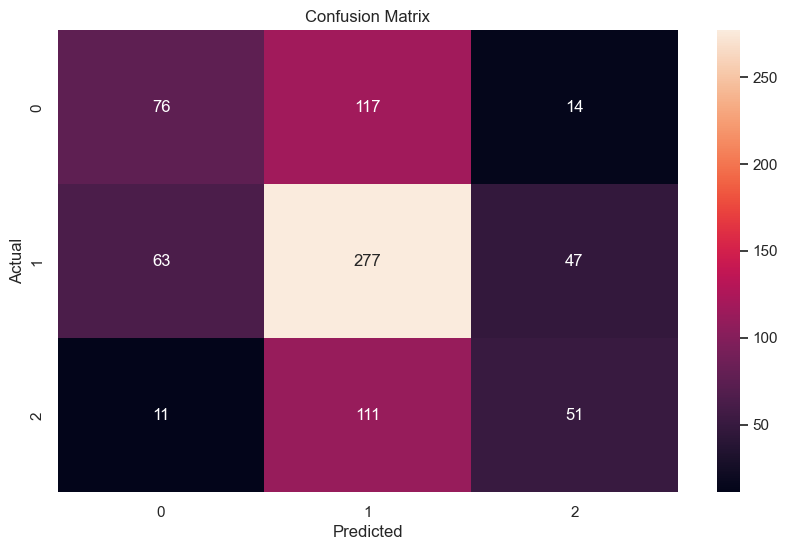

In [62]:
plot_confusion_matrix(test_y_m2, pred_y_m2)

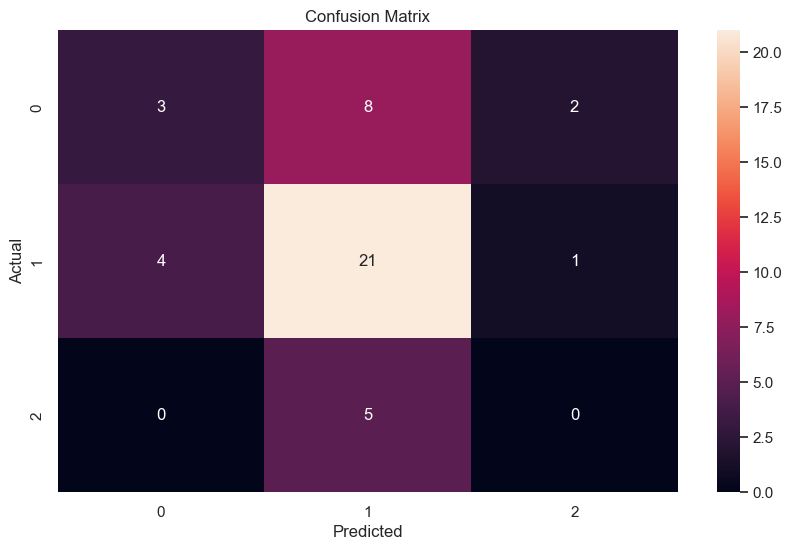

In [63]:
plot_confusion_matrix(test_y_agg_m2, pred_y_agg_m2)


### 2b. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors as bins)

In [64]:
df_labelled_m2b = df_labelled.copy()
df_train_test_m2b = df_labelled_m2b[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment', 'article_index', 'label']]
df_train_test_m2b

,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,4990000,1290000,0.000000,1,36,0.482143,0.228571,4d/toto,trending
1,Blackpink's Born Pink is highest grossing tour...,707314,350734,0.452778,1,22,0.155556,-0.033333,4d/toto,diminishing
2,$201k jackpot: US man wins lottery 3 times in ...,12310000,2230000,3.332222,1,28,0.285417,0.200000,4d/toto,trending
3,"Singapore resident wins $122,000 on India's Wh...",4990000,1290000,39.490000,3,29,0.133333,0.233333,4d/toto,trending
4,Jacky Cheung S'pore concert tickets sell out f...,6770000,1660000,26.147778,4,15,0.600000,0.200000,4d/toto,diminishing
...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,12310000,2230000,1.655833,4,18,0.433333,0.016667,world cup,diminishing
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",6770000,1660000,36.267500,6,23,0.192593,-0.074074,world cup,neutral
3837,Wong Li Lin didn't defend her act of clinging ...,6770000,1660000,53.563611,1,14,0.844444,0.075000,world cup,neutral
3838,Manchester United discusses granting exclusivi...,14760000,2330000,85.344444,4,24,0.000000,0.000000,world cup,neutral


In [65]:
# Normalise mean_monthly_visits and mean_monthly_unique_visitors

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors'].max()

# converting mean_monthly_visits and mean_monthly_unique_visitors to bin

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

# converting hours_since_published to bin

df_train_test_m2b['hours_since_published'] = df_train_test_m2b['hours_since_published'].apply(lambda x: "lowest" if x < 1 else ("low" if x < 2 else ("moderate" if x < 3 else "high")))

# converting text_non_stop_word_count to bin

df_train_test_m2b['text_non_stop_word_count'] = df_train_test_m2b['text_non_stop_word_count'].apply(lambda x: "lowest" if x < 5 else ("low" if x < 10 else ("moderate" if x < 15 else "high")))

# converting text_subjectivity to bin

df_train_test_m2b['text_subjectivity'] = df_train_test_m2b['text_subjectivity'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

# converting text_sentiment to bin

df_train_test_m2b['text_sentiment'] = df_train_test_m2b['text_sentiment'].apply(lambda x: "lowest" if x < -0.25 else ("low" if x < 0 else ("moderate" if x < 0.25 else "high")))

# convert day_of_week_published to day

df_train_test_m2b['day_of_week_published'] = df_train_test_m2b['day_of_week_published'].apply(lambda x: "Monday" if x == 0 else ("Tuesday" if x == 1 else ("Wednesday" if x == 2 else ("Thursday" if x == 3 else ("Friday" if x == 4 else ("Saturday" if x == 5 else "Sunday"))))))

df_train_test_m2b.head(10)

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\3681521824.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\3681521824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors'].m

,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,low,moderate,lowest,Tuesday,high,low,moderate,4d/toto,trending
1,Blackpink's Born Pink is highest grossing tour...,lowest,lowest,lowest,Tuesday,high,lowest,low,4d/toto,diminishing
2,$201k jackpot: US man wins lottery 3 times in ...,high,high,high,Tuesday,high,low,moderate,4d/toto,trending
3,"Singapore resident wins $122,000 on India's Wh...",low,moderate,high,Thursday,high,lowest,moderate,4d/toto,trending
4,Jacky Cheung S'pore concert tickets sell out f...,low,moderate,high,Friday,high,moderate,moderate,4d/toto,diminishing
5,Let it rip: Kids play Beyblades at Yishun void...,low,moderate,high,Friday,high,high,high,4d/toto,neutral
6,M'sian retiree spends S$1.20 on lottery ticket...,low,moderate,lowest,Friday,high,low,low,4d/toto,trending
7,Huat ah! Punter wins $5.5m Toto from Bukit Mer...,low,moderate,high,Saturday,high,low,moderate,4d/toto,trending
8,'Queued for more than 4 hours and suddenly sol...,low,moderate,moderate,Saturday,high,moderate,high,4d/toto,neutral
9,The Glory star Song Hye-kyo wins her first Bes...,lowest,lowest,high,Tuesday,high,moderate,high,4d/toto,neutral


In [66]:
label_mapper = {"trending": 2, "diminishing": 0, "neutral": 1}
df_train_test_m2b["label"] = df_train_test_m2b["label"].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2b["text"] = (
    df_train_test_m2b["text"]
    + " There are "
    + df_train_test_m2b["mean_monthly_visits"].astype(str)
    + " mean monthly visitors to the website and "
    + df_train_test_m2b["mean_monthly_unique_visitors"].astype(str)
    + " mean monthly unique visitors to the website."
    + " The article was published "
    + df_train_test_m2b["hours_since_published"].astype(str)
    + " hours after the last article of the same theme was published."
    + " The article was published on the "
    + df_train_test_m2b["day_of_week_published"].astype(str)
    + " day of the week."
    + " The headline has "
    + df_train_test_m2b["text_non_stop_word_count"].astype(str)
    + " non-stop words."
    + " The text has a subjectivity score of "
    + df_train_test_m2b["text_subjectivity"].astype(str)
    + " and a sentiment score of "
    + df_train_test_m2b["text_sentiment"].astype(str)
    + "."
)
df_train_test_m2b.drop(
    columns=["mean_monthly_visits", "mean_monthly_unique_visitors"], inplace=True
)
df_train_test_m2b.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\924750376.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b["label"] = df_train_test_m2b["label"].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\924750376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b["text"] = (
e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,text,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,lowest,Tuesday,high,low,moderate,4d/toto,2
1,Blackpink's Born Pink is highest grossing tour...,lowest,Tuesday,high,lowest,low,4d/toto,0
2,$201k jackpot: US man wins lottery 3 times in ...,high,Tuesday,high,low,moderate,4d/toto,2
3,"Singapore resident wins $122,000 on India's Wh...",high,Thursday,high,lowest,moderate,4d/toto,2
4,Jacky Cheung S'pore concert tickets sell out f...,high,Friday,high,moderate,moderate,4d/toto,0


In [67]:
df_train_test_m2b.text.iloc[0]

'\'I don\'t have the heart to criticise them\': Jacky Cheung on why he rejected 9-digit pay to be mentor on singing competition "Everyone who has the courage to sing on stage â€” even though they aren\'t professional singers â€” are already amazing for being daring enough to sing in front of a large crowd. I don\'t have the heart to criticise them." said Jacky Cheung. There are low mean monthly visitors to the website and moderate mean monthly unique visitors to the website. The article was published lowest hours after the last article of the same theme was published. The article was published on the Tuesday day of the week. The headline has high non-stop words. The text has a subjectivity score of low and a sentiment score of moderate.'

In [68]:
# Train test split

train_df_m2b, test_df_m2b = train_test_split(df_train_test_m2b, test_size=0.2, random_state=42, stratify=df_train_test_m2b['article_index'])

train_df_m2b.to_parquet('data/train_df_m2b.parquet')
test_df_m2b.to_parquet('data/test_df_m2b.parquet')


dataset_m2b = load_dataset("parquet", data_files={'train': "data/train_df_m2b.parquet", 'test': "data/test_df_m2b.parquet"})
train_dataset_m2b = dataset_m2b["train"]
test_dataset_m2b = dataset_m2b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 999.95it/s]
Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-674483ea19466b93/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 785.01it/s]


In [69]:
# Load a SetFit model
model_m2b = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2b = SetFitTrainer(
    model=model_m2b,
    train_dataset=train_dataset_m2b,
    eval_dataset=test_dataset_m2b,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [70]:
trainer_m2b.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:01<00:00, 11.81it/s]
***** Running training *****
  Num examples = 122640
  Num epochs = 1
  Total optimization steps = 7665
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [18:32<00:00, 1112.32s/it]


In [71]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

In [72]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

res_m2b = evaluate_predictions(test_y_m2b, pred_y_m2b)
res_m2b


,macro
accuracy,0.542
precision,0.514
recall,0.475
f1,0.483


In [73]:
test_y_agg_m2b, pred_y_agg_m2b = get_predictions_agg(test_dataset_m2b, pred_y_m2b)
res_agg_m2b = evaluate_predictions(test_y_agg_m2b, pred_y_agg_m2b)
res_agg_m2b

,macro
accuracy,0.591
precision,0.459
recall,0.438
f1,0.439


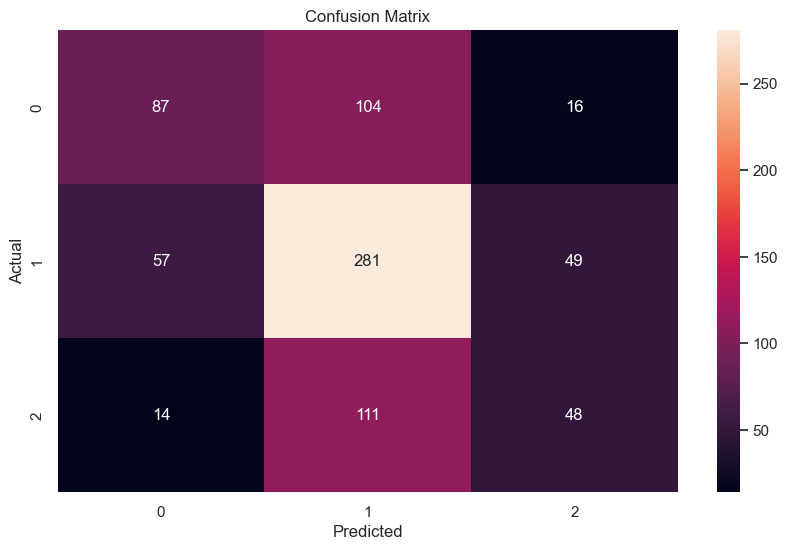

In [74]:
plot_confusion_matrix(test_y_m2b, pred_y_m2b)


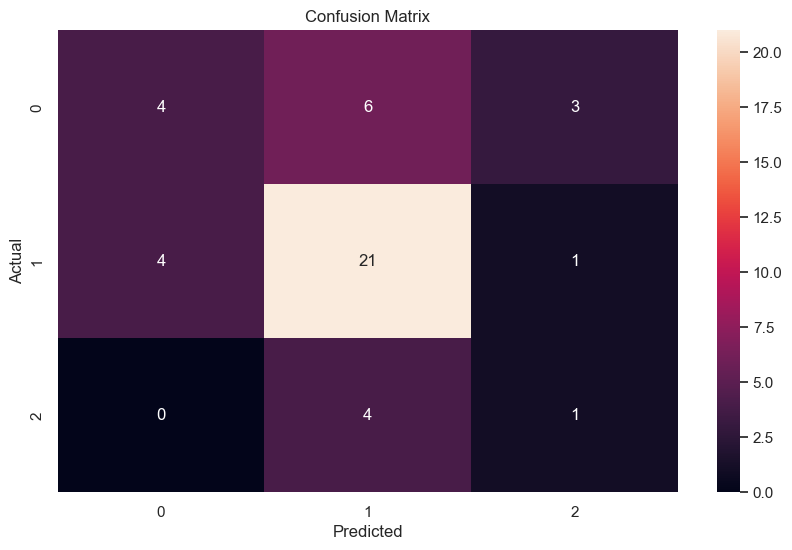

In [75]:
plot_confusion_matrix(test_y_agg_m2b, pred_y_agg_m2b)


### 3. Combined models - Concat text embeddings with numerical features

In [76]:
df_labelled_m3 = df_labelled.copy()
df_train_test_m3 = df_labelled_m3[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)
df_train_test_m3

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\632900511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,4990000,1290000,0.000000,1,36,0.482143,0.228571,4d/toto,2
1,Blackpink's Born Pink is highest grossing tour...,707314,350734,0.452778,1,22,0.155556,-0.033333,4d/toto,0
2,$201k jackpot: US man wins lottery 3 times in ...,12310000,2230000,3.332222,1,28,0.285417,0.200000,4d/toto,2
3,"Singapore resident wins $122,000 on India's Wh...",4990000,1290000,39.490000,3,29,0.133333,0.233333,4d/toto,2
4,Jacky Cheung S'pore concert tickets sell out f...,6770000,1660000,26.147778,4,15,0.600000,0.200000,4d/toto,0
...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,12310000,2230000,1.655833,4,18,0.433333,0.016667,world cup,0
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",6770000,1660000,36.267500,6,23,0.192593,-0.074074,world cup,1
3837,Wong Li Lin didn't defend her act of clinging ...,6770000,1660000,53.563611,1,14,0.844444,0.075000,world cup,1
3838,Manchester United discusses granting exclusivi...,14760000,2330000,85.344444,4,24,0.000000,0.000000,world cup,1


In [77]:
df_train_test_m3.label.value_counts()

1    1939
0    1015
2     879
Name: label, dtype: int64

In [78]:
# Create train, val and test datasets

train_val_df_m3, test_df_m3 = train_test_split(df_train_test_m3, test_size=0.2, random_state=42, stratify=df_train_test_m3['article_index'])
train_df_m3, val_df_m3 = train_test_split(train_val_df_m3, test_size=0.2, random_state=42, stratify=train_val_df_m3['article_index'])

In [79]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m3_mean_monthly_visit = MinMaxScaler()
train_df_m3[['mean_monthly_visits']] = scaler_m3_mean_monthly_visit.fit_transform(train_df_m3[['mean_monthly_visits']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df

val_df_m3[['mean_monthly_visits']] = scaler_m3_mean_monthly_visit.transform(val_df_m3[['mean_monthly_visits']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m3[['mean_monthly_visits']] = scaler_m3_mean_monthly_visit.transform(test_df_m3[['mean_monthly_visits']])

scaler_m3_mean_monthly_unique = MinMaxScaler()
train_df_m3[['mean_monthly_unique_visitors']] = scaler_m3_mean_monthly_unique.fit_transform(train_df_m3[['mean_monthly_unique_visitors']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df

val_df_m3[['mean_monthly_unique_visitors']] = scaler_m3_mean_monthly_unique.transform(val_df_m3[['mean_monthly_unique_visitors']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m3[['mean_monthly_unique_visitors']] = scaler_m3_mean_monthly_unique.transform(test_df_m3[['mean_monthly_unique_visitors']])

# normalising hours_since_published on train_df

scaler_m3_hours = MinMaxScaler()
train_df_m3[['hours_since_published']] = scaler_m3_hours.fit_transform(train_df_m3[['hours_since_published']])

# normalising hours_since_published on val_df

val_df_m3[['hours_since_published']] = scaler_m3_hours.transform(val_df_m3[['hours_since_published']])

# normalising hours_since_published on test_df

test_df_m3[['hours_since_published']] = scaler_m3_hours.transform(test_df_m3[['hours_since_published']])

# normalising text_non_stop_word_count on train_df

scaler_m3_text = MinMaxScaler()

train_df_m3[['text_non_stop_word_count']] = scaler_m3_text.fit_transform(train_df_m3[['text_non_stop_word_count']])

# normalising text_non_stop_word_count on val_df

val_df_m3[['text_non_stop_word_count']] = scaler_m3_text.transform(val_df_m3[['text_non_stop_word_count']])

# normalising text_non_stop_word_count on test_df

test_df_m3[['text_non_stop_word_count']] = scaler_m3_text.transform(test_df_m3[['text_non_stop_word_count']])


train_df_m3

,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
3021,South Korean actress Park Soo-ryun dies at 29 ...,0.832321,0.955429,0.000104,2,0.126050,0.344444,-0.177778,others,1
929,When to give your baby water: A guide for pare...,0.331335,0.536461,0.000538,7,0.117647,0.433333,0.000000,ndp,0
727,Fewer Singaporean tourists in Johor this Hari ...,0.832321,0.955429,0.000000,2,0.117647,0.375000,-0.225000,hari raya,0
3241,Man Requests Refund From US Chinese Restaurant...,0.127382,0.328548,0.001092,3,0.100840,0.000000,0.000000,others,0
2363,Tourists bitten after interacting with monkeys...,0.832321,0.955429,0.000123,3,0.126050,0.000000,0.000000,others,1
...,...,...,...,...,...,...,...,...,...,...
2368,K-idol Lee Seung-gi baffles 4.4m Instagram fol...,0.038226,0.117819,0.000002,3,0.075630,0.312500,0.000000,others,0
1162,"Boy, 14, arrested after allegedly taking 2 gol...",0.453160,0.701374,0.000071,1,0.126050,0.100000,-0.100000,others,0
408,Bedok 'cai png' stall sells S$2 dishes so that...,0.453160,0.701374,0.000744,2,0.336134,0.000000,0.000000,food prices,1
2895,UMNO Youth Wing Leading Protest March to US Em...,0.050823,0.167292,0.000041,5,0.235294,0.553000,0.222000,others,0


In [80]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [81]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[['mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment']].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [82]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [83]:
# Create Datasets
train_dataset_m3 = CustomDataset(train_df_m3)
val_dataset_m3 = CustomDataset(val_df_m3)
test_dataset_m3 = CustomDataset(test_df_m3)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3 = DataLoader(train_dataset_m3, batch_size=batch_size, shuffle=True)
val_dataloader_m3 = DataLoader(val_dataset_m3, batch_size=batch_size, shuffle=False)
test_dataloader_m3 = DataLoader(test_dataset_m3, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3 = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3 = NumericModel(7, 64, 512)  

# Instantiate FinalModel
final_model_m3 = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3 = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3 = Adam(list(numeric_model_m3.parameters()) + list(final_model_m3.parameters()) + list(sentence_model_m3.parameters()), lr=0.0001)

In [84]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3 = []
val_losses_m3 = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3, optimizer_m3)
    valid_loss = evaluate(val_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3)
    train_losses_m3.append(train_loss)
    val_losses_m3.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3[epoch-1] < val_losses_m3[epoch] and val_losses_m3[epoch-2] < val_losses_m3[epoch-1]:
        break

Epoch 0: Train Loss: 1.0447588942267678, Validation Loss: 1.0456515371799469
Epoch 1: Train Loss: 1.026706406048366, Validation Loss: 1.0424044907093049
Epoch 2: Train Loss: 1.0201237867404889, Validation Loss: 1.0451946169137956
Epoch 3: Train Loss: 1.0167688015219454, Validation Loss: 1.0416563123464584
Epoch 4: Train Loss: 1.011115619114467, Validation Loss: 1.044887539744377
Epoch 5: Train Loss: 1.0117862851588757, Validation Loss: 1.0404587745666505
Epoch 6: Train Loss: 1.0075426465505128, Validation Loss: 1.0386772215366364
Epoch 7: Train Loss: 1.0045339379991804, Validation Loss: 1.0368023931980133
Epoch 8: Train Loss: 1.0025834696633475, Validation Loss: 1.0327284783124924
Epoch 9: Train Loss: 0.9997859465611445, Validation Loss: 1.0292842835187912
Epoch 10: Train Loss: 0.9953970700115352, Validation Loss: 1.0288131445646287
Epoch 11: Train Loss: 0.99213259405904, Validation Loss: 1.0255148619413377
Epoch 12: Train Loss: 0.991469281060355, Validation Loss: 1.022990494966507
Epo

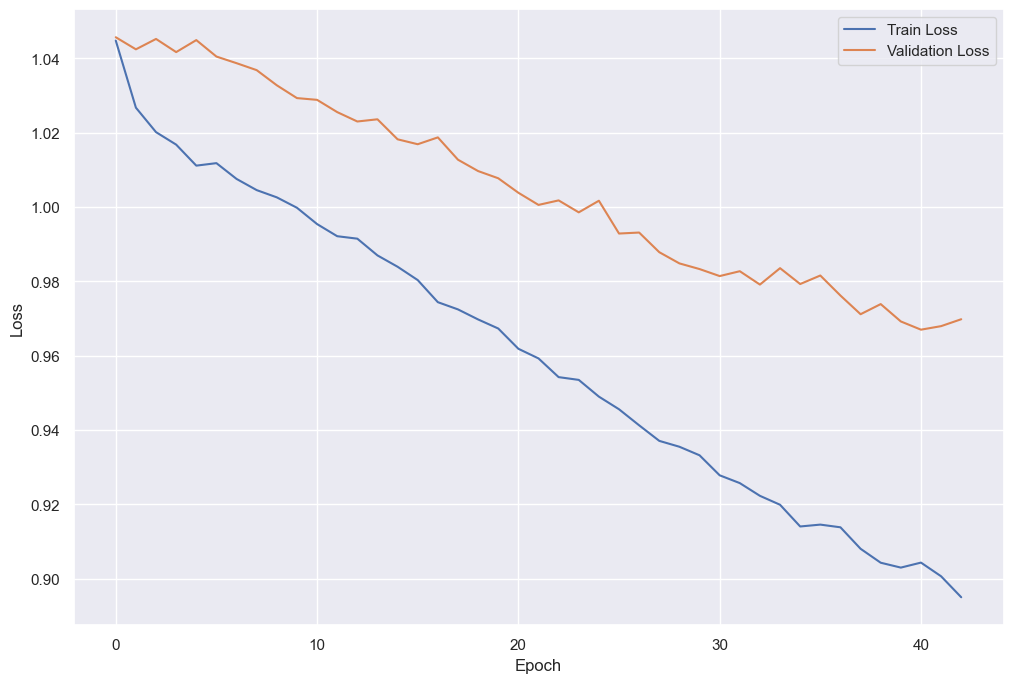

In [85]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3, label='Train Loss')
plt.plot(val_losses_m3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
final_model_m3.eval()  # Set the model to evaluation mode
sentence_model_m3.eval()
numeric_model_m3.eval()

pred_y_m3 = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3:  # We don't care about labels here
        texts = [sentence_model_m3.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3 = np.array(pred_y_m3)  # Convert predictions to NumPy array

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\2447301300.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  texts = torch.tensor(texts, dtype=torch.float)


In [87]:
# plot confusion matrix

test_y_m3 = test_df_m3['label'].values

res_m3 = evaluate_predictions(test_y_m3, pred_y_m3)
res_m3

,macro
accuracy,0.537
precision,0.571
recall,0.399
f1,0.367


In [88]:
test_y_agg_m3, pred_y_agg_m3 = get_predictions_agg(test_df_m3, pred_y_m3)
res_agg_m3 = evaluate_predictions(test_y_agg_m3, pred_y_agg_m3)
res_agg_m3

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,macro
accuracy,0.636
precision,0.458
recall,0.397
f1,0.370


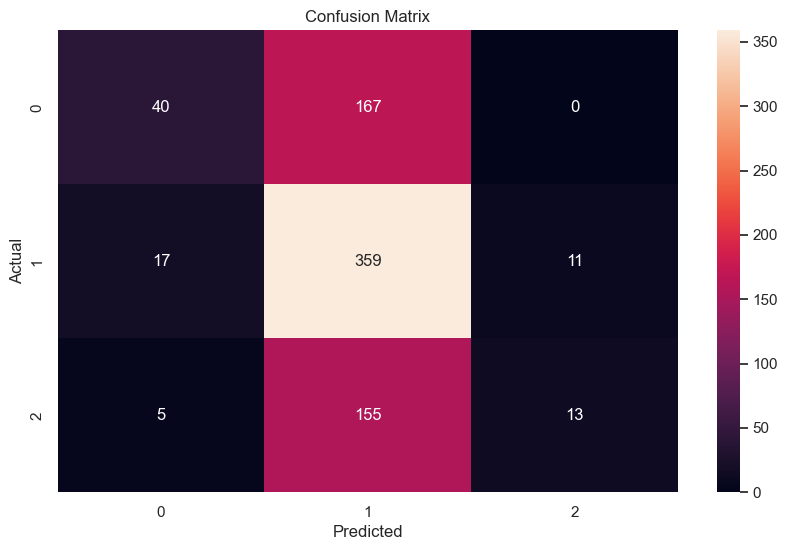

In [89]:
plot_confusion_matrix(test_y_m3, pred_y_m3)

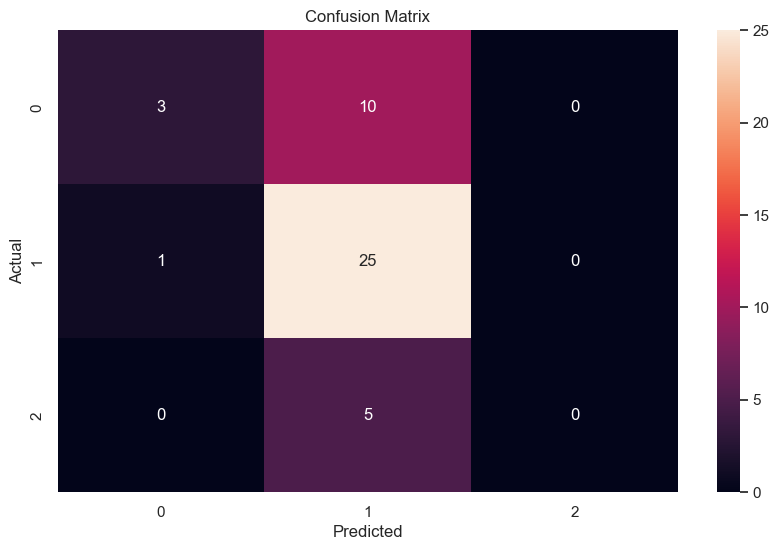

In [90]:
plot_confusion_matrix(test_y_agg_m3, pred_y_agg_m3)

### 3b. Combined models - Concat text embeddings with numerical features (one hot encoding of domains only)

In [91]:
df_labelled_m3b = df_labelled.copy()
df_train_test_m3b = df_labelled_m3b[['text', 'domain_group', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)

# one-hot encode domain_group
df_train_test_m3b = pd.get_dummies(df_train_test_m3b, columns=['domain_group'])

df_train_test_m3b

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\3506505909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)


,text,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label,domain_group_asiaone,domain_group_businesstimes,...,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,'I don't have the heart to criticise them': Ja...,0.000000,1,36,0.482143,0.228571,4d/toto,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Blackpink's Born Pink is highest grossing tour...,0.452778,1,22,0.155556,-0.033333,4d/toto,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,$201k jackpot: US man wins lottery 3 times in ...,3.332222,1,28,0.285417,0.200000,4d/toto,2,0,0,...,0,0,0,0,0,1,0,0,0,0
3,"Singapore resident wins $122,000 on India's Wh...",39.490000,3,29,0.133333,0.233333,4d/toto,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Jacky Cheung S'pore concert tickets sell out f...,26.147778,4,15,0.600000,0.200000,4d/toto,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,1.655833,4,18,0.433333,0.016667,world cup,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",36.267500,6,23,0.192593,-0.074074,world cup,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3837,Wong Li Lin didn't defend her act of clinging ...,53.563611,1,14,0.844444,0.075000,world cup,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3838,Manchester United discusses granting exclusivi...,85.344444,4,24,0.000000,0.000000,world cup,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
domain_group_cols = list(df_train_test_m3b.columns[8:])
domain_group_cols

numeric_cols = domain_group_cols + ['hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment']
numeric_cols

['domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore',
 'hours_since_published',
 'day_of_week_published',
 'text_non_stop_word_count',
 'text_subjectivity',
 'text_sentiment']

In [93]:
# Create train, val and test datasets
train_val_df_m3b, test_df_m3b = train_test_split(df_train_test_m3b, test_size=0.2, random_state=42, stratify=df_train_test_m3b['article_index'])
train_df_m3b, val_df_m3b = train_test_split(train_val_df_m3b, test_size=0.2, random_state=42, stratify=train_val_df_m3b['article_index'])

In [94]:
# normalising hours_since_published on train_df

scaler_m3b_hours = MinMaxScaler()
train_df_m3b[['hours_since_published']] = scaler_m3b_hours.fit_transform(train_df_m3b[['hours_since_published']])

# normalising hours_since_published on val_df

val_df_m3b[['hours_since_published']] = scaler_m3b_hours.transform(val_df_m3b[['hours_since_published']])

# normalising hours_since_published on test_df

test_df_m3b[['hours_since_published']] = scaler_m3b_hours.transform(test_df_m3b[['hours_since_published']])

# normalising text_non_stop_word_count on train_df

scaler_m3b_text = MinMaxScaler()

train_df_m3b[['text_non_stop_word_count']] = scaler_m3b_text.fit_transform(train_df_m3b[['text_non_stop_word_count']])

# normalising text_non_stop_word_count on val_df

val_df_m3b[['text_non_stop_word_count']] = scaler_m3b_text.transform(val_df_m3b[['text_non_stop_word_count']])

# normalising text_non_stop_word_count on test_df

test_df_m3b[['text_non_stop_word_count']] = scaler_m3b_text.transform(test_df_m3b[['text_non_stop_word_count']])


train_df_m3b

,text,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label,domain_group_asiaone,domain_group_businesstimes,...,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
3021,South Korean actress Park Soo-ryun dies at 29 ...,0.000104,2,0.126050,0.344444,-0.177778,others,1,0,0,...,0,0,0,0,0,1,0,0,0,0
929,When to give your baby water: A guide for pare...,0.000538,7,0.117647,0.433333,0.000000,ndp,0,1,0,...,0,0,0,0,0,0,0,0,0,0
727,Fewer Singaporean tourists in Johor this Hari ...,0.000000,2,0.117647,0.375000,-0.225000,hari raya,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3241,Man Requests Refund From US Chinese Restaurant...,0.001092,3,0.100840,0.000000,0.000000,others,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2363,Tourists bitten after interacting with monkeys...,0.000123,3,0.126050,0.000000,0.000000,others,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,K-idol Lee Seung-gi baffles 4.4m Instagram fol...,0.000002,3,0.075630,0.312500,0.000000,others,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1162,"Boy, 14, arrested after allegedly taking 2 gol...",0.000071,1,0.126050,0.100000,-0.100000,others,0,0,0,...,0,1,0,0,0,0,0,0,0,0
408,Bedok 'cai png' stall sells S$2 dishes so that...,0.000744,2,0.336134,0.000000,0.000000,food prices,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2895,UMNO Youth Wing Leading Protest March to US Em...,0.000041,5,0.235294,0.553000,0.222000,others,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [95]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [96]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[numeric_cols].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [97]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [98]:
# Create Datasets
train_dataset_m3b = CustomDataset(train_df_m3b)
val_dataset_m3b = CustomDataset(val_df_m3b)
test_dataset_m3b = CustomDataset(test_df_m3b)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3b = DataLoader(train_dataset_m3b, batch_size=batch_size, shuffle=True)
val_dataloader_m3b = DataLoader(val_dataset_m3b, batch_size=batch_size, shuffle=False)
test_dataloader_m3b = DataLoader(test_dataset_m3b, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3b = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3b = NumericModel(len(numeric_cols), 64, 512)  

# Instantiate FinalModel
final_model_m3b = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3b = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3b = Adam(list(numeric_model_m3b.parameters()) + list(final_model_m3b.parameters()) + list(sentence_model_m3b.parameters()), lr=0.0001)

In [99]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3b = []
val_losses_m3b = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b, optimizer_m3b)
    valid_loss = evaluate(val_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b)
    train_losses_m3b.append(train_loss)
    val_losses_m3b.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3b[epoch-1] < val_losses_m3b[epoch] and val_losses_m3b[epoch-2] < val_losses_m3b[epoch-1]:
        break

Epoch 0: Train Loss: 1.0468971628647346, Validation Loss: 1.0401487559080125
Epoch 1: Train Loss: 1.0205105937920607, Validation Loss: 1.034950077533722
Epoch 2: Train Loss: 1.0068260702219876, Validation Loss: 1.0326608538627624
Epoch 3: Train Loss: 0.9985894870448422, Validation Loss: 1.0245018154382706
Epoch 4: Train Loss: 0.991922901822375, Validation Loss: 1.0174331367015839
Epoch 5: Train Loss: 0.9821287269716139, Validation Loss: 1.0109687060117722
Epoch 6: Train Loss: 0.9750335611306228, Validation Loss: 1.0019422709941863
Epoch 7: Train Loss: 0.9681550241135931, Validation Loss: 0.9987399607896805
Epoch 8: Train Loss: 0.9618245131009585, Validation Loss: 0.9905251264572144
Epoch 9: Train Loss: 0.9552701734877252, Validation Loss: 0.9958101093769074
Epoch 10: Train Loss: 0.9513558451231424, Validation Loss: 0.9890514582395553
Epoch 11: Train Loss: 0.944420220015885, Validation Loss: 0.9778403013944625
Epoch 12: Train Loss: 0.9395517350791337, Validation Loss: 0.9774884819984436

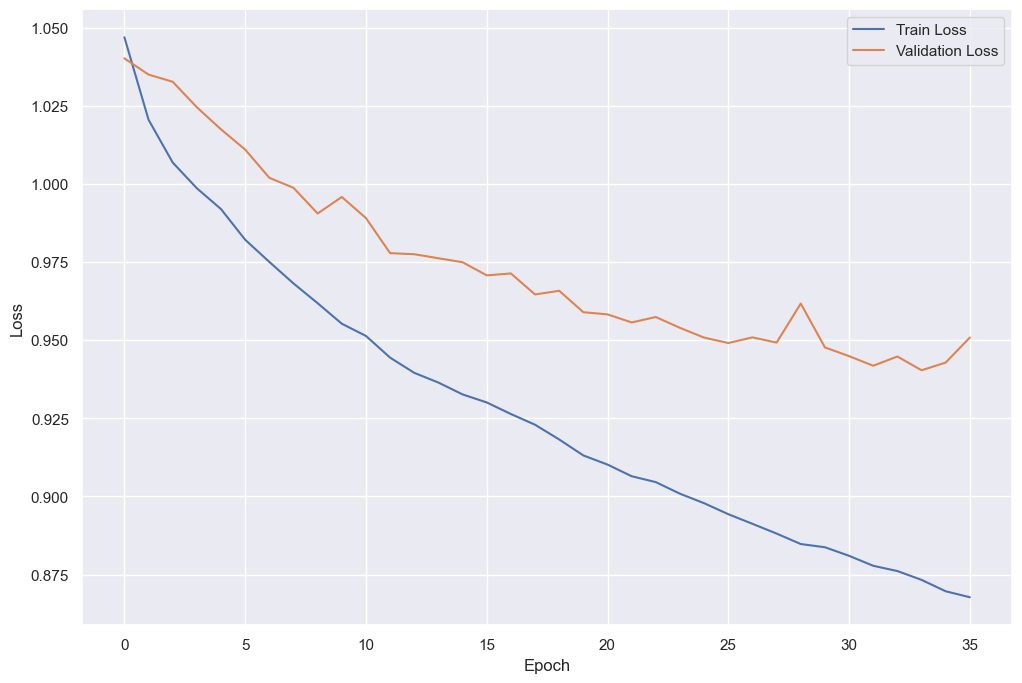

In [100]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3b, label='Train Loss')
plt.plot(val_losses_m3b, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
final_model_m3b.eval()  # Set the model to evaluation mode
sentence_model_m3b.eval()
numeric_model_m3b.eval()

pred_y_m3b = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3b:  # We don't care about labels here
        texts = [sentence_model_m3b.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3b(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3b(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3b.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3b = np.array(pred_y_m3b)  # Convert predictions to NumPy array

In [102]:
# plot confusion matrix

test_y_m3b = test_df_m3b['label'].values

res_m3b = evaluate_predictions(test_y_m3b, pred_y_m3b)
res_m3b

,macro
accuracy,0.535
precision,0.500
recall,0.434
f1,0.430


In [103]:
test_y_agg_m3b, pred_y_agg_m3b = get_predictions_agg(test_df_m3b, pred_y_m3b)
res_agg_m3b = evaluate_predictions(test_y_agg_m3b, pred_y_agg_m3b)
res_agg_m3b

,macro
accuracy,0.614
precision,0.455
recall,0.385
f1,0.364


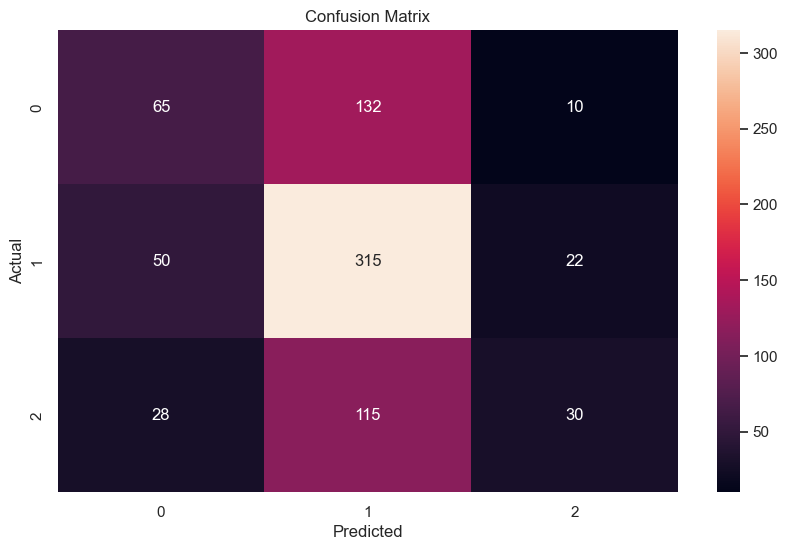

In [104]:
plot_confusion_matrix(test_y_m3b, pred_y_m3b)


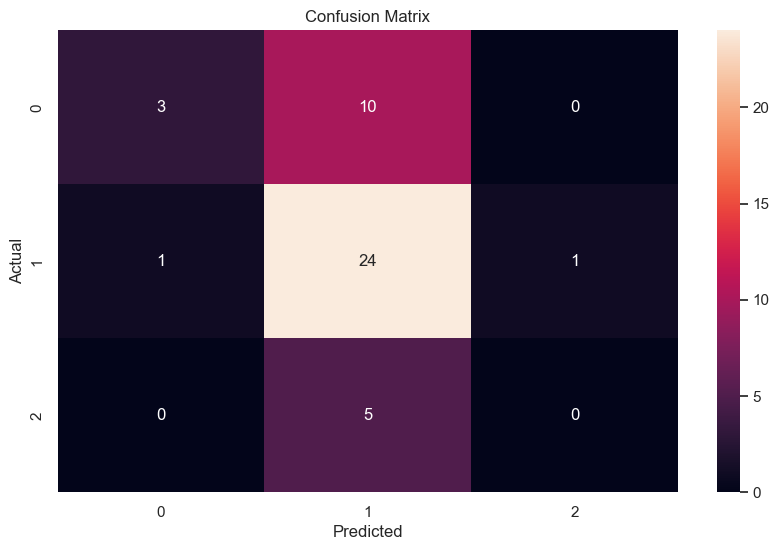

In [105]:
plot_confusion_matrix(test_y_agg_m3b, pred_y_agg_m3b)

### 4. Multimodel Transformers

In [106]:
df_labelled_m4 = df_labelled.copy()
df_train_test_m4 = df_labelled_m4[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)
df_train_test_m4

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\1377224653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
0,'I don't have the heart to criticise them': Ja...,4990000,1290000,0.000000,1,36,0.482143,0.228571,4d/toto,2
1,Blackpink's Born Pink is highest grossing tour...,707314,350734,0.452778,1,22,0.155556,-0.033333,4d/toto,0
2,$201k jackpot: US man wins lottery 3 times in ...,12310000,2230000,3.332222,1,28,0.285417,0.200000,4d/toto,2
3,"Singapore resident wins $122,000 on India's Wh...",4990000,1290000,39.490000,3,29,0.133333,0.233333,4d/toto,2
4,Jacky Cheung S'pore concert tickets sell out f...,6770000,1660000,26.147778,4,15,0.600000,0.200000,4d/toto,0
...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,12310000,2230000,1.655833,4,18,0.433333,0.016667,world cup,0
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",6770000,1660000,36.267500,6,23,0.192593,-0.074074,world cup,1
3837,Wong Li Lin didn't defend her act of clinging ...,6770000,1660000,53.563611,1,14,0.844444,0.075000,world cup,1
3838,Manchester United discusses granting exclusivi...,14760000,2330000,85.344444,4,24,0.000000,0.000000,world cup,1


In [107]:
# Train test split

train_df_m4, test_df_m4 = train_test_split(df_train_test_m4, test_size=0.2, random_state=42, stratify=df_train_test_m4['article_index'])

In [108]:
df_train_test_m4.article_index.value_counts().reset_index()

,index,article_index
0,others,2122
1,sea games,299
2,food prices,229
3,ndp,168
4,border reopening,112
5,football,108
6,deaths,77
7,4d/toto,69
8,ndr,56
9,weather,51


In [109]:
train_df_m4.article_index.value_counts()


others                      1697
sea games                    239
food prices                  183
ndp                          134
border reopening              89
football                      86
deaths                        61
4d/toto                       55
ndr                           45
weather                       41
scams                         40
layoffs                       29
mbs                           27
world cup                     25
earthquake                    23
parliament                    22
winter olympics               18
hari raya                     18
crypto                        17
msia politics                 16
nsf                           15
chicken supply                14
resale prices                 14
landslide                     13
taxi fares                    12
g20                           12
service disruptions           10
safe management measures      10
local athletes                 9
coe prices                     9
workplace 

In [110]:
test_df_m4.article_index.value_counts()


others                      425
sea games                    60
food prices                  46
ndp                          34
border reopening             23
football                     22
deaths                       16
4d/toto                      14
ndr                          11
weather                      10
scams                        10
mbs                           7
layoffs                       7
parliament                    6
world cup                     6
earthquake                    6
crypto                        4
nsf                           4
winter olympics               4
msia politics                 4
hari raya                     4
resale prices                 3
g20                           3
chicken supply                3
taxi fares                    3
service disruptions           3
safe management measures      3
landslide                     3
healthcare                    2
workplace safety              2
local athletes                2
coe pric

In [111]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m4_mean_monthly_visit = MinMaxScaler()
train_df_m4[['mean_monthly_visits']] = scaler_m4_mean_monthly_visit.fit_transform(train_df_m4[['mean_monthly_visits']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m4[['mean_monthly_visits']] = scaler_m4_mean_monthly_visit.transform(test_df_m4[['mean_monthly_visits']])

scaler_m4_mean_monthly_unique = MinMaxScaler()
train_df_m4[['mean_monthly_unique_visitors']] = scaler_m4_mean_monthly_unique.fit_transform(train_df_m4[['mean_monthly_unique_visitors']])

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m4[['mean_monthly_unique_visitors']] = scaler_m4_mean_monthly_unique.transform(test_df_m4[['mean_monthly_unique_visitors']])


# normalising hours_since_published on train_df

scaler_m4_hours = MinMaxScaler()
train_df_m4[['hours_since_published']] = scaler_m4_hours.fit_transform(train_df_m4[['hours_since_published']])

# normalising hours_since_published on test_df

test_df_m4[['hours_since_published']] = scaler_m4_hours.transform(test_df_m4[['hours_since_published']])

# normalising text_non_stop_word_count on train_df

scaler_m4_text = MinMaxScaler()

train_df_m4[['text_non_stop_word_count']] = scaler_m4_text.fit_transform(train_df_m4[['text_non_stop_word_count']])

# normalising text_non_stop_word_count on test_df

test_df_m4[['text_non_stop_word_count']] = scaler_m4_text.transform(test_df_m4[['text_non_stop_word_count']])


train_df_m3

,text,mean_monthly_visits,mean_monthly_unique_visitors,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label
3021,South Korean actress Park Soo-ryun dies at 29 ...,0.832321,0.955429,0.000104,2,0.126050,0.344444,-0.177778,others,1
929,When to give your baby water: A guide for pare...,0.331335,0.536461,0.000538,7,0.117647,0.433333,0.000000,ndp,0
727,Fewer Singaporean tourists in Johor this Hari ...,0.832321,0.955429,0.000000,2,0.117647,0.375000,-0.225000,hari raya,0
3241,Man Requests Refund From US Chinese Restaurant...,0.127382,0.328548,0.001092,3,0.100840,0.000000,0.000000,others,0
2363,Tourists bitten after interacting with monkeys...,0.832321,0.955429,0.000123,3,0.126050,0.000000,0.000000,others,1
...,...,...,...,...,...,...,...,...,...,...
2368,K-idol Lee Seung-gi baffles 4.4m Instagram fol...,0.038226,0.117819,0.000002,3,0.075630,0.312500,0.000000,others,0
1162,"Boy, 14, arrested after allegedly taking 2 gol...",0.453160,0.701374,0.000071,1,0.126050,0.100000,-0.100000,others,0
408,Bedok 'cai png' stall sells S$2 dishes so that...,0.453160,0.701374,0.000744,2,0.336134,0.000000,0.000000,food prices,1
2895,UMNO Youth Wing Leading Protest March to US Em...,0.050823,0.167292,0.000041,5,0.235294,0.553000,0.222000,others,0


In [112]:
train_df_m4.to_parquet('data/train_df_m4.parquet')
test_df_m4.to_parquet('data/test_df_m4.parquet')

dataset_m4 = load_dataset("parquet", data_files={'train': "data/train_df_m4.parquet", 'test': "data/test_df_m4.parquet"})
train_dataset_m4 = dataset_m4["train"]
test_dataset_m4 = dataset_m4["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1000.07it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-5c0d5e302bbbf2bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.83it/s]


In [113]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = ['mean_monthly_visits', 'mean_monthly_unique_visitors', 'hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment']
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4 = test_df_m4.reset_index(drop=True)
test_df_m4

test_dataset_m4 = load_data(
    test_df_m4,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

In [114]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset.numerical_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4 = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'tabular_combiner.num_bn

In [115]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer = Trainer(
  model=model_m4,
  args=training_args,
  train_dataset=torch_dataset,
  eval_dataset=test_dataset_m4,
)

trainer.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  5%|▌         | 25/480 [04:10<1:17:02, 10.16s/it]

{'loss': 1.0558, 'learning_rate': 4.739583333333333e-05, 'epoch': 0.26}


 10%|█         | 50/480 [08:24<1:12:49, 10.16s/it]

{'loss': 1.0489, 'learning_rate': 4.4791666666666673e-05, 'epoch': 0.52}


 16%|█▌        | 75/480 [12:38<1:08:40, 10.17s/it]

{'loss': 1.0089, 'learning_rate': 4.21875e-05, 'epoch': 0.78}


 21%|██        | 100/480 [16:51<1:03:19, 10.00s/it]

{'loss': 0.9626, 'learning_rate': 3.958333333333333e-05, 'epoch': 1.04}


 26%|██▌       | 125/480 [21:05<1:00:06, 10.16s/it]

{'loss': 0.9488, 'learning_rate': 3.697916666666667e-05, 'epoch': 1.3}


 31%|███▏      | 150/480 [25:19<55:53, 10.16s/it]  

{'loss': 0.9417, 'learning_rate': 3.4375e-05, 'epoch': 1.56}


 36%|███▋      | 175/480 [29:34<51:47, 10.19s/it]

{'loss': 0.9126, 'learning_rate': 3.177083333333333e-05, 'epoch': 1.82}


 42%|████▏     | 200/480 [33:46<47:19, 10.14s/it]

{'loss': 0.8692, 'learning_rate': 2.916666666666667e-05, 'epoch': 2.08}


 47%|████▋     | 225/480 [38:00<43:13, 10.17s/it]

{'loss': 0.7291, 'learning_rate': 2.6562500000000002e-05, 'epoch': 2.34}


 52%|█████▏    | 250/480 [42:14<39:00, 10.18s/it]

{'loss': 0.715, 'learning_rate': 2.3958333333333334e-05, 'epoch': 2.6}


 57%|█████▋    | 275/480 [46:28<34:47, 10.18s/it]

{'loss': 0.7281, 'learning_rate': 2.1354166666666666e-05, 'epoch': 2.86}


 62%|██████▎   | 300/480 [50:40<30:28, 10.16s/it]

{'loss': 0.6422, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.12}


 68%|██████▊   | 325/480 [54:55<26:17, 10.17s/it]

{'loss': 0.5116, 'learning_rate': 1.6145833333333334e-05, 'epoch': 3.39}


 73%|███████▎  | 350/480 [59:09<22:04, 10.19s/it]

{'loss': 0.4849, 'learning_rate': 1.3541666666666666e-05, 'epoch': 3.65}


 78%|███████▊  | 375/480 [1:03:23<17:48, 10.17s/it]

{'loss': 0.5298, 'learning_rate': 1.09375e-05, 'epoch': 3.91}


 83%|████████▎ | 400/480 [1:07:35<13:32, 10.15s/it]

{'loss': 0.375, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}


 89%|████████▊ | 425/480 [1:11:49<09:19, 10.18s/it]

{'loss': 0.316, 'learning_rate': 5.729166666666667e-06, 'epoch': 4.43}


 94%|█████████▍| 450/480 [1:16:04<05:05, 10.17s/it]

{'loss': 0.3468, 'learning_rate': 3.125e-06, 'epoch': 4.69}


 99%|█████████▉| 475/480 [1:20:18<00:50, 10.16s/it]

{'loss': 0.3208, 'learning_rate': 5.208333333333334e-07, 'epoch': 4.95}


100%|██████████| 480/480 [1:21:06<00:00, 10.14s/it]

{'train_runtime': 4866.8133, 'train_samples_per_second': 3.15, 'train_steps_per_second': 0.099, 'train_loss': 0.7033625920613606, 'epoch': 5.0}


TrainOutput(global_step=480, training_loss=0.7033625920613606, metrics={'train_runtime': 4866.8133, 'train_samples_per_second': 3.15, 'train_steps_per_second': 0.099, 'train_loss': 0.7033625920613606, 'epoch': 5.0})

In [116]:

pred_y_m4 = trainer.predict(test_dataset_m4)


  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:06<00:00, 15.85it/s]


In [117]:
test_y_m4 = test_df_m4['label']
pred_y_m4 = pred_y_m4.predictions[0].argmax(axis=1)

res_m4 = evaluate_predictions(test_y_m4, pred_y_m4)
res_m4

,macro
accuracy,0.527
precision,0.498
recall,0.457
f1,0.465


In [118]:
test_y_agg_m4, pred_y_agg_m4 = get_predictions_agg(test_df_m4, pred_y_m4)
res_agg_m4 = evaluate_predictions(test_y_agg_m4, pred_y_agg_m4)
res_agg_m4

,macro
accuracy,0.614
precision,0.574
recall,0.438
f1,0.450


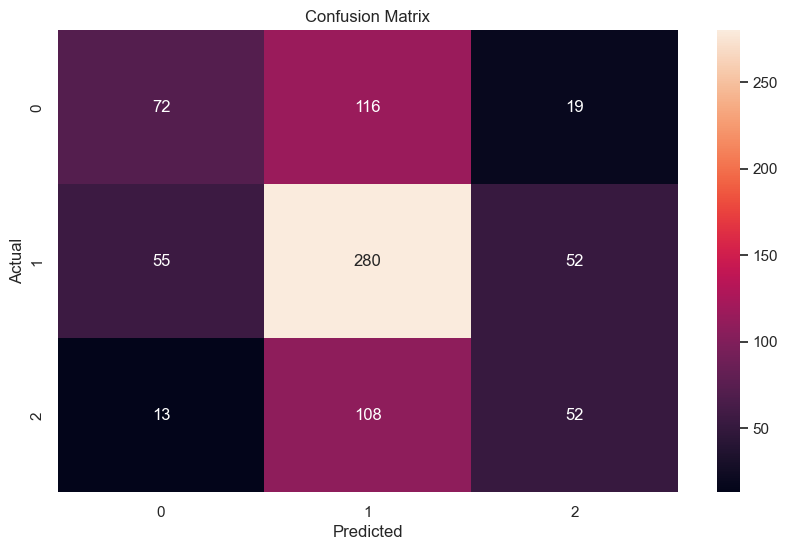

In [119]:
plot_confusion_matrix(test_y_m4, pred_y_m4)


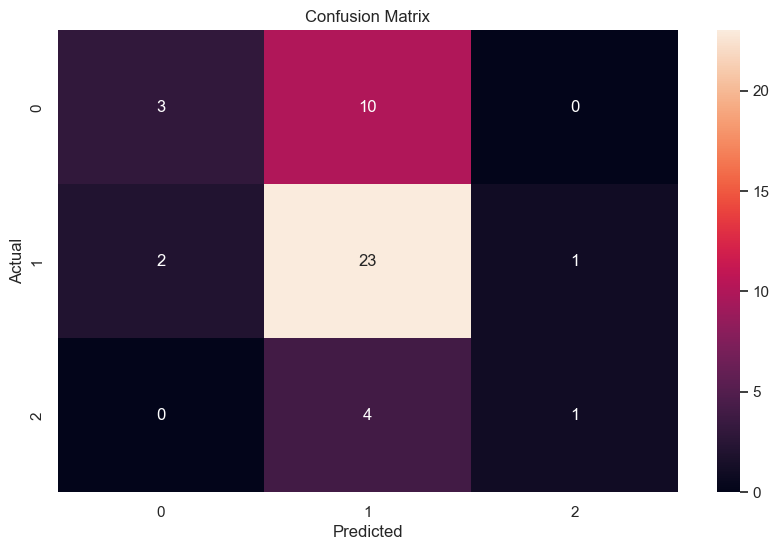

In [120]:
plot_confusion_matrix(test_y_agg_m4, pred_y_agg_m4)


### 4b. Multimodel Transformers with categorical domain encoding

In [121]:
df_labelled_m4b = df_labelled.copy()
df_train_test_m4b = df_labelled_m4b[['text', 'domain_group','hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment','article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)

df_train_test_m4b = pd.get_dummies(df_train_test_m4b, columns=['domain_group'])

df_train_test_m4b

C:\Users\edmun\AppData\Local\Temp\ipykernel_4376\1662929719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)


,text,hours_since_published,day_of_week_published,text_non_stop_word_count,text_subjectivity,text_sentiment,article_index,label,domain_group_asiaone,domain_group_businesstimes,...,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,'I don't have the heart to criticise them': Ja...,0.000000,1,36,0.482143,0.228571,4d/toto,2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Blackpink's Born Pink is highest grossing tour...,0.452778,1,22,0.155556,-0.033333,4d/toto,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,$201k jackpot: US man wins lottery 3 times in ...,3.332222,1,28,0.285417,0.200000,4d/toto,2,0,0,...,0,0,0,0,0,1,0,0,0,0
3,"Singapore resident wins $122,000 on India's Wh...",39.490000,3,29,0.133333,0.233333,4d/toto,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Jacky Cheung S'pore concert tickets sell out f...,26.147778,4,15,0.600000,0.200000,4d/toto,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Players at Women's World Cup guaranteed at lea...,1.655833,4,18,0.433333,0.016667,world cup,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3836,"Danelle Tan, 18, will be 1st S'porean & Asian ...",36.267500,6,23,0.192593,-0.074074,world cup,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3837,Wong Li Lin didn't defend her act of clinging ...,53.563611,1,14,0.844444,0.075000,world cup,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3838,Manchester United discusses granting exclusivi...,85.344444,4,24,0.000000,0.000000,world cup,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
domain_group_cols = list(df_train_test_m4b.columns[8:])
domain_group_cols

numeric_cols = domain_group_cols + ['hours_since_published', 'day_of_week_published', 'text_non_stop_word_count', 'text_subjectivity', 'text_sentiment']
numeric_cols

['domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore',
 'hours_since_published',
 'day_of_week_published',
 'text_non_stop_word_count',
 'text_subjectivity',
 'text_sentiment']

In [123]:
train_df_m4b, test_df_m4b = train_test_split(df_train_test_m4b, test_size=0.2, random_state=42, stratify=df_train_test_m4b['article_index'])


In [124]:
train_df_m4b.to_parquet('data/train_df_m4b.parquet')
test_df_m4b.to_parquet('data/test_df_m4b.parquet')

dataset_m4b = load_dataset("parquet", data_files={'train': "data/train_df_m4b.parquet", 'test': "data/test_df_m4b.parquet"})
train_dataset_m4b = dataset_m4b["train"]
test_dataset_m4b = dataset_m4b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1049.36it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-4f6a284ba3b69f09/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 990.62it/s]


In [125]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4b.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = numeric_cols
# categorical_cols = domain_group_cols
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset_m4b = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4b = test_df_m4b.reset_index(drop=True)
test_df_m4b

test_dataset_m4b = load_data(
    test_df_m4b,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

In [126]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset_m4b.numerical_feats.shape[1],
    # cat_feat_dim=torch_dataset_m4b.cat_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4b = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'tabular_combiner.num_bn

In [127]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer_m4b = Trainer(
  model=model_m4b,
  args=training_args,
  train_dataset=torch_dataset_m4b,
  eval_dataset=test_dataset_m4b,
)

trainer_m4b.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  5%|▌         | 25/480 [06:22<1:57:36, 15.51s/it]

{'loss': 1.0578, 'learning_rate': 4.739583333333333e-05, 'epoch': 0.26}


 10%|█         | 50/480 [12:50<1:51:04, 15.50s/it]

{'loss': 1.027, 'learning_rate': 4.4791666666666673e-05, 'epoch': 0.52}


 16%|█▌        | 75/480 [19:17<1:44:53, 15.54s/it]

{'loss': 0.9788, 'learning_rate': 4.21875e-05, 'epoch': 0.78}


 21%|██        | 100/480 [25:42<1:37:00, 15.32s/it]

{'loss': 0.9397, 'learning_rate': 3.958333333333333e-05, 'epoch': 1.04}


 26%|██▌       | 125/480 [32:10<1:31:49, 15.52s/it]

{'loss': 0.8828, 'learning_rate': 3.697916666666667e-05, 'epoch': 1.3}


 31%|███▏      | 150/480 [38:38<1:25:08, 15.48s/it]

{'loss': 0.8756, 'learning_rate': 3.4375e-05, 'epoch': 1.56}


 36%|███▋      | 175/480 [45:05<1:18:35, 15.46s/it]

{'loss': 0.8391, 'learning_rate': 3.177083333333333e-05, 'epoch': 1.82}


 42%|████▏     | 200/480 [51:30<1:12:03, 15.44s/it]

{'loss': 0.7839, 'learning_rate': 2.916666666666667e-05, 'epoch': 2.08}


 47%|████▋     | 225/480 [57:56<1:05:49, 15.49s/it]

{'loss': 0.5872, 'learning_rate': 2.6562500000000002e-05, 'epoch': 2.34}


 52%|█████▏    | 250/480 [1:04:24<59:23, 15.49s/it]  

{'loss': 0.5723, 'learning_rate': 2.3958333333333334e-05, 'epoch': 2.6}


 57%|█████▋    | 275/480 [1:10:51<52:57, 15.50s/it]

{'loss': 0.5409, 'learning_rate': 2.1354166666666666e-05, 'epoch': 2.86}


 62%|██████▎   | 300/480 [1:17:16<46:32, 15.51s/it]

{'loss': 0.4671, 'learning_rate': 1.8750000000000002e-05, 'epoch': 3.12}


 68%|██████▊   | 325/480 [1:23:44<40:05, 15.52s/it]

{'loss': 0.3272, 'learning_rate': 1.6145833333333334e-05, 'epoch': 3.39}


 73%|███████▎  | 350/480 [1:30:11<33:33, 15.49s/it]

{'loss': 0.2762, 'learning_rate': 1.3541666666666666e-05, 'epoch': 3.65}


 78%|███████▊  | 375/480 [1:36:38<27:06, 15.49s/it]

{'loss': 0.3082, 'learning_rate': 1.09375e-05, 'epoch': 3.91}


 83%|████████▎ | 400/480 [1:43:03<20:39, 15.49s/it]

{'loss': 0.188, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}


 89%|████████▊ | 425/480 [1:49:30<14:10, 15.47s/it]

{'loss': 0.1637, 'learning_rate': 5.729166666666667e-06, 'epoch': 4.43}


 94%|█████████▍| 450/480 [1:55:57<07:45, 15.51s/it]

{'loss': 0.1655, 'learning_rate': 3.125e-06, 'epoch': 4.69}


 99%|█████████▉| 475/480 [2:02:24<01:17, 15.47s/it]

{'loss': 0.1728, 'learning_rate': 5.208333333333334e-07, 'epoch': 4.95}


100%|██████████| 480/480 [2:03:39<00:00, 15.46s/it]

{'train_runtime': 7419.4806, 'train_samples_per_second': 2.066, 'train_steps_per_second': 0.065, 'train_loss': 0.582279606287678, 'epoch': 5.0}


TrainOutput(global_step=480, training_loss=0.582279606287678, metrics={'train_runtime': 7419.4806, 'train_samples_per_second': 2.066, 'train_steps_per_second': 0.065, 'train_loss': 0.582279606287678, 'epoch': 5.0})

In [128]:
pred_y_m4b = trainer_m4b.predict(test_dataset_m4b)


  0%|          | 0/96 [00:00<?, ?it/s]

100%|██████████| 96/96 [00:06<00:00, 15.81it/s]


In [129]:
test_y_m4b = test_df_m4b['label']
pred_y_m4b = pred_y_m4b.predictions[0].argmax(axis=1)

res_m4b = evaluate_predictions(test_y_m4b, pred_y_m4b)
res_m4b

,macro
accuracy,0.531
precision,0.501
recall,0.456
f1,0.463


In [130]:
test_y_agg_m4b, pred_y_agg_m4b = get_predictions_agg(test_df_m4b, pred_y_m4b)
res_agg_m4b = evaluate_predictions(test_y_agg_m4b, pred_y_agg_m4b)
res_agg_m4b

,macro
accuracy,0.545
precision,0.428
recall,0.400
f1,0.400


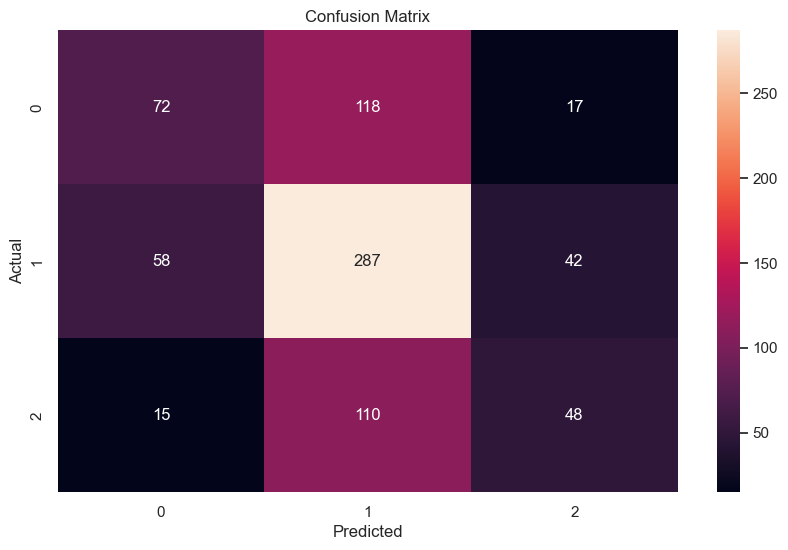

In [131]:
plot_confusion_matrix(test_y_m4b, pred_y_m4b)


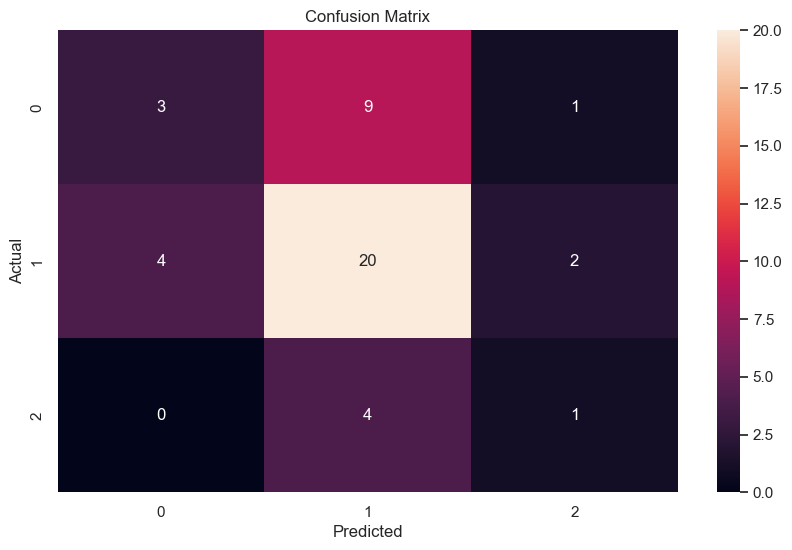

In [132]:
plot_confusion_matrix(test_y_agg_m4b, pred_y_agg_m4b)


### Comaparing Results M1, M2, M2b, M3, M3b, M4, M4b

In [133]:
# combine res_m1, res_m2, res_m3 into a dataframe

res_df = pd.concat([res_m1, res_m2, res_m2b, res_m3, res_m3b, res_m4, res_m4b], axis=1, keys=['SetFit (Text Only)', 'SetFit (Text + numerical)', 'SetFit (Text + binned numerical)', 'Concat (Visitor Count)', 'Concat (One-hot domain)','Multimodal (Visitor Count)','Multimodal (One-hot domain)']).droplevel(1, axis=1).T
res_df

,accuracy,precision,recall,f1
SetFit (Text Only),0.536,0.513,0.468,0.478
SetFit (Text + numerical),0.527,0.504,0.459,0.468
SetFit (Text + binned numerical),0.542,0.514,0.475,0.483
Concat (Visitor Count),0.537,0.571,0.399,0.367
Concat (One-hot domain),0.535,0.500,0.434,0.430
Multimodal (Visitor Count),0.527,0.498,0.457,0.465
Multimodal (One-hot domain),0.531,0.501,0.456,0.463


In [134]:
res_agg_df = pd.concat([res_agg_m1, res_agg_m2, res_agg_m2b, res_agg_m3, res_agg_m3b, res_agg_m4, res_agg_m4b], axis=1, keys=['SetFit (Text Only)', 'SetFit (Text + numerical)', 'SetFit (Text + binned numerical)', 'Concat (Visitor Count)', 'Concat (One-hot domain)','Multimodal (Visitor Count)','Multimodal (One-hot domain)']).droplevel(1, axis=1).T
res_agg_df.sort_values(by='f1', ascending=False)

,accuracy,precision,recall,f1
Multimodal (Visitor Count),0.614,0.574,0.438,0.450
SetFit (Text + binned numerical),0.591,0.459,0.438,0.439
Multimodal (One-hot domain),0.545,0.428,0.400,0.400
Concat (Visitor Count),0.636,0.458,0.397,0.370
Concat (One-hot domain),0.614,0.455,0.385,0.364
SetFit (Text + numerical),0.545,0.349,0.346,0.333
SetFit (Text Only),0.545,0.343,0.346,0.330


In [135]:
# res_df.to_csv('results_100.csv')

In [138]:
# res_100 = pd.read_csv('results_100.csv', index_col=0)
# res_100["threshold"] = 1.00

# res_90 = pd.read_csv('results_090.csv', index_col=0)
# res_90["threshold"] = 0.90

# res_80 = pd.read_csv('results_080.csv', index_col=0)
# res_80["threshold"] = 0.80

# # concat all results
# res_df_combined = pd.concat([res_100, res_90, res_80], axis=0)
# res_df_combined.sort_values(by=['f1'], ascending=False)

In [139]:
# res_100.sort_values(by=['f1'], ascending=False)